In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torchinfo # do funkcji summary

In [ ]:
import numpy as np
import torch
from scipy.signal import convolve2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt

### Jak zrobić zadanie

Notebook składa się z 4 zadań, jednak **najważniejsze są zadania 3 i 4**, bo dotyczą stricte własnej implementacji sieci konwolucyjnej. W poszczególnych sekcjach znajdują się opisy które powinny wystarczyć do zrozumienia i implementacji, ale poniżej zamieszczone są źródła do dalszej nauki.

Zbiorem danych będzie *FashionMNIST* lub *CIFAR10* (w zależności od waszej preferencji).

Źródła
- https://visionbook.mit.edu/convolutional_neural_nets.html -> na pograniczu CV i CNN
- https://engineering.purdue.edu/DeepLearn/pdf-kak/DemystifyConvo.pdf -> przydatne do zadania z konwolucją
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks#layer -> wizualizacje
- https://guandi1995.github.io/Padding/ -> objaśnienie paddingu
- https://cs231n.github.io/convolutional-networks/ -> kurs od stanford
- warstwy w PyTorch: [Conv2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [MaxPool2d
](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d), [BatchNorm2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d), [Dropout2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#torch.nn.Dropout2d)


### 0. Po co nam coś więcej niż MLP?

Na poprzedniej liście spłaszczaliśmy obrazki, aby móc je przepuścić przez sieć FNN, jednak taki preprocessing do formy tabelarycznej gubi istotne informacje. Po pierwsze, piksele blisko siebie w oryginalnym obrazie mogą znaleźć się daleko od siebie, dodatkowo wszystkie piksele będą "wymieniać" się sygnałami z wszystkimi innymi pikselami. Jest to mechanizm dosyć nieefektywny (w szarym obrazku o rozmiarze 128x128 mamy na wejściu już 16 384 cech!) i tu na pomoc przychodzą konwolucje.

### 1. Konwolucja

Podstawową operację konwolucji jest lepiej sobie zobrazować (pun intended) na podstawie jednego, oczywistego przykładu. Załóżmy, że mamy obraz binarny (czyli składający się z 0 i 1). Jest to typowa reprezentacja maski w zadaniu segmentacji - 1 oznacza, że na danym pikselu jest interesujący nas obiekt, a 0 to tło.

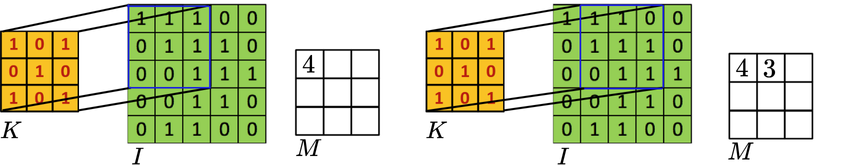

Wyjaśnienie symboli na obrazku
- $I$ - obrazek wejściowy
- $K$ - filtr (kernel) o wymiarze 3x3
- $M$ - wyjściowa mapa cech

Wynik przesuwania się filtra po wejściowej mapie można opisać wzorem

$$(K ⋆ I)(i, j) = \sum_{a=0}^{H_k-1}\sum_{b=0}^{W_k-1} K(a, b)I(i + a, j + b)$$

opisuje to jaki będzie wynik w pikselu o współrzędnych (i, j) w wynikowej mapie $M$. $H_k$ i $W_k$ oznaczają odpowiednio wysokość i szerokość filtra - często rozważamy kwadratowe rozmiary, $H_k$ = $W_k$.


(Tak naprawdę wzór wyżej opisuje korelację wzajemną - *cross-correlation*, ponieważ matematyczna operacja konwolucji dałaby wynik obrócony o 180 stopni)

Taka prosta formulacja nie uwzględnia faktu, że obrazki (zwykle) zawierają kanał koloru RGB. W takim razie filtr $K$ ma teraz możliwe współrzędne $K_{a,b,d}$. Wiemy już z poprzednich list, że budująć sieć neuronową chcemy zwiększyć liczbę ukrytych wymiarów. Dlatego też, aby zwiększyć liczbę kanałów z 3 (rgb) na $Q_k$, nasz filtr musi mieć 4 wymiary, więc indeksować się jako $K_{a,b,d,q}$. To oznacza, że mamy $Q_k$ pojedynczych filtrów, które będą przesuwać się po wejściowym obrazku. Ostatecznie konwolucja będzie mieć postać

$$M_{i,j,q} = \sum_{a=0}^{H_k-1}\sum_{b=0}^{W_k-1}\sum_{d=0}^{D_I-1}K(a, b, d, q)I(i + a, j + b, d)$$

Wynikowy rozmiar takiej mapy nie jest domyślnie równy wejściowemu obrazkowi (lub mapie). Wynika to z tego, że musimy wybrać tylko te "kawałki" obrazka, które w pełni mieszczą się w filtrze (później powiemy o paddingu). Zakładając, że obrazki są mają wymiar $H_I \times W_I \times D_I$, kernel $H_k \times W_k \times D_I \times Q_k$ to wynikowy rozmiar ma postać $$(H_I - H_k + 1) \times (W_I - W_k + 1) \times Q_k$$

Przesuwając kolejno filtr o jedną pozycję (jak dalej się dowiemy, krok jaki wykonuje filtr odnosi się do parametru *stride*) obliczamy wynikową mapę. Wartości w mapie $W$ nie są zwykle z góry znane (tym bardziej nie są binarne jak w prostym przykładzie wyżej), ale wyuczane w procesie trenowania sieci.


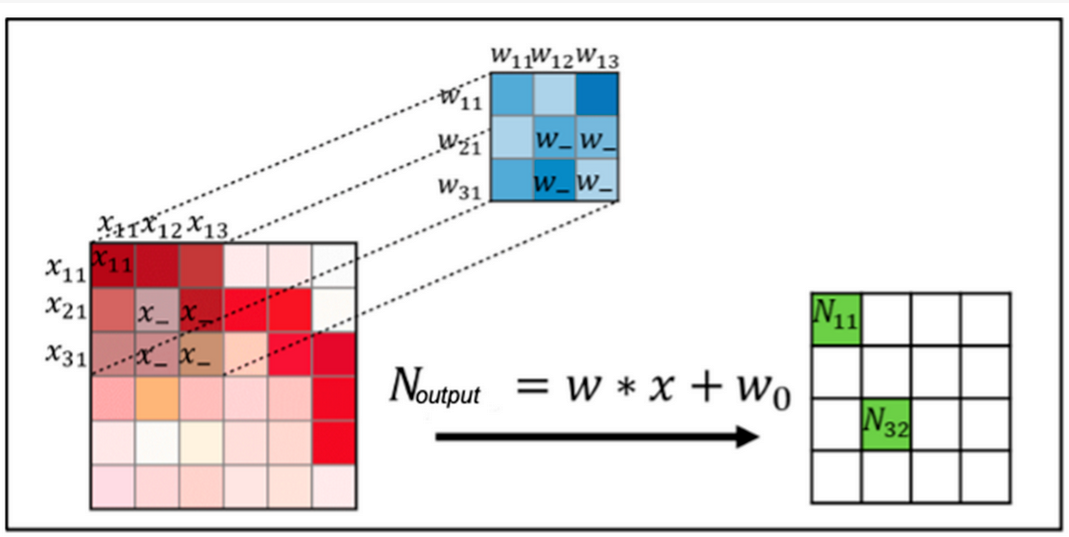

Polecam zajrzeć tutaj po interaktywną wizualizację https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks

### Zadanie 1
Bazując na opisie wyżej i wiarygodnych źródłach, napisz własną implementację operacji konwolucji. Może ona opierać się na macierzach NumPy lub PyTorch. Wykorzystaj poniższą linijkę z testami, aby sprawdzić swoje rozwiązanie.

Ekstra: pomyśl, czy dałoby się zapisać taką operację czysto w sposób macierzowy, pozbywając się pętli (lub chociaż ograniczając ich liczbę).

*Ekstra: pomyśl o dodaniu paddingu (może być to wartość 0), aby mapa wyjściowa była równa rozmiarowo wejściu (wtedy też musisz zmienić padding w testach).

In [ ]:
def convolution(X, K, q: int):
  '''
  Wykonuje operację konwolucji na wejściowym obrazie *X* oraz filtrze *K*. Zwraca wynikową mapę.
  Args:
    X: numpy / torch tensor o wymiarach (h, w, d)
    K: numpy / torch tensor o wymiarach (k, k, d, q)
    q: liczba filtrów
  '''
  h_i, w_i, d_i = X.shape
  h_k, w_k, _, q_out = K.shape

  h_out = h_i - h_k + 1
  w_out = w_i - w_k + 1

  output_map = torch.zeros(h_out, w_out, q_out)

  # pierwotna wersja
  #for i in range(h_out):
  #  for j in range(w_out):
  #    for Q in range(q):
  #      for a in range(h_k):
  #        for b in range(w_k):
  #          for d in range(d_i):
  #            output_map[i][j][Q] += K[a][b][d][Q] * X[i+a][j+b][d]

  # zmniejszenie liczby pętli
  for i in range(h_out):
    for j in range(w_out):
      img_patch = X[i:i+h_k, j:j+w_k]
      for Q in range(q):
        kernel = K[:, :, :, Q]
        output_map[i][j][Q] = (img_patch * kernel).sum()

  return output_map

#### Przypadki testowe
Nie musisz nic tutaj modyfikować z wyjątkiem gdy używasz NumPy (w kodzie są zaznaczone linijki, które trzeba odkomentować)

In [ ]:
def generate_deterministic_tensor(shape, mod_val=5, offset=0):
    count = 1
    for s in shape:
        count *= s
    # Tworzymy sekwencję 0, 1, 2... i bierzemy modulo
    data = torch.arange(count).float() % mod_val + offset
    return data.reshape(shape)

def torch_2_numpy(pt):
  return pt.detach().numpy()

def run_pytorch_test(case_name, img_hwc, kernel_hwcn):
    image_hwc = generate_deterministic_tensor(img_hwc, mod_val=5)
    kernel_hwcn = generate_deterministic_tensor(kernel_hwcn, mod_val=3, offset=-1)

    print(f"Input shape (H,W,C): {tuple(image_hwc.shape)}")
    print(f"Kernel shape (H,W,Cin,Cout): {tuple(kernel_hwcn.shape)}")

    # Dodanie wymiaru batcha
    input_tensor = image_hwc.permute(2, 0, 1).unsqueeze(0)
    weights = kernel_hwcn.permute(3, 2, 0, 1)
    output_tensor = F.conv2d(input_tensor, weights, stride=1, padding=0)
    output_hwc = output_tensor.squeeze(0).permute(1, 2, 0)

    # ODKOMENTUJ JEŚLI twoim inputem jest wielowymiarowa macierz NumPy
    # image_hwc = torch_2_numpy(image_hwc)
    # kernel_hwcn = torch_2_numpy(kernel_hwcn)

    my_output = convolution(image_hwc, kernel_hwcn, kernel_hwcn.shape[-1])
    if isinstance(my_output, np.ndarray):
        my_output = torch.from_numpy(my_output)

    my_output = my_output.to(torch.float64)
    output_hwc = output_hwc.to(torch.float64) # do samego typu żeby nie było błędu

    try:
      torch.testing.assert_close(my_output, output_hwc, rtol=1e-05, atol=1e-08)
      print(f"Test zaliczony")
    except AssertionError as e:
      print(f"Test niezaliczony: {e}")
    print(f"Output shape (H,W,C): {tuple(output_hwc.shape)}")

# --- URUCHOMIENIE PRZYPADKÓW ---

# Przypadek 1: Mały
run_pytorch_test("PRZYPADEK 1", (6, 6, 3), (3, 3, 3, 5))
print("-" * 30)
# Przypadek 2: Średni
run_pytorch_test("PRZYPADEK 2", (12, 12, 3), (3, 3, 3, 5))
print("-" * 30)
# Przypadek 3: Projekcja 1x1
run_pytorch_test("PRZYPADEK 3", (24, 24, 3), (1, 1, 3, 10))

Input shape (H,W,C): (6, 6, 3)
Kernel shape (H,W,Cin,Cout): (3, 3, 3, 5)
Test zaliczony
Output shape (H,W,C): (4, 4, 5)
------------------------------
Input shape (H,W,C): (12, 12, 3)
Kernel shape (H,W,Cin,Cout): (3, 3, 3, 5)
Test zaliczony
Output shape (H,W,C): (10, 10, 5)
------------------------------
Input shape (H,W,C): (24, 24, 3)
Kernel shape (H,W,Cin,Cout): (1, 1, 3, 10)
Test zaliczony
Output shape (H,W,C): (24, 24, 10)


### 2. Porównanie konwolucji i sieci w pełni połączonej

| Cecha | Konwolucja (CNN) | Sieć w pełni połączona (FNN / Dense) |
| :--- | :--- | :--- |
| **1. Wagi/Parametry** | **Współdzielone (Parameter Sharing)**<br>Ten sam zestaw wag (filtr) jest używany do skanowania całego obrazu | **Indywidualne**<br>Każde połączenie ma własną wagę przypisaną do konkretnego piksela/pozycji na wejściu |
| **2. Zasięg działania** | **Lokalny**<br>Operacja dotyczy tylko małego wycinka (okna) wokół aktualnie przetwarzanego punktu | **Globalny**<br>Każdy neuron w warstwie ukrytej "widzi" i jest połączony ze wszystkimi pikselami obrazu wejściowego |
| **3. Przesunięcie obiektu** | **Ekwiwariancja na translację**<br>Jeśli obiekt (np. kot) przesunie się na obrazie, sieć nadal go wykryje (tylko w innym miejscu mapy cech) | **Wrażliwość na pozycję**<br>Sieć musi "nauczyć się" wyglądu kota w każdym możliwym położeniu osobno, traktując je jako zupełnie nowe wzorce |
| **Efektywność** | Mniejsza liczba parametrów (dzięki współdzieleniu wag), szybsze uczenie obrazów | Ogromna liczba parametrów przy dużych obrazach, wysokie ryzyko przeuczenia |

### 3. Pole recepcyjne

Po angielsku *receptive field* odnosi się do wszystkich możliwych miejsc na obrazku, jak i na poprzednich mapach, które mogą wpływać na wynik w aktualnie rozważanym elemencie. Lepiej to obrazuje załączony schemat, gdzie widzimy jak element po środku tak naprawdę posiada informacje z poprzednich warstw. Jest to główna koncepcja w kontekście projektowania architektur konwolucyjnych sieci neuronowych, gdzie głębsze warstwy uczą się bardziej skomplikowanych struktur bazując na prymitywnych kształtach zidentyfikowanych na niższych warstwach.

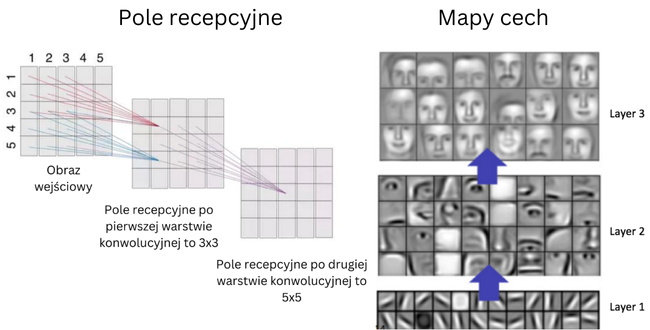

### 4. Operacja Poolingu

Aby jeszcze bardziej zmniejszyć rozmiar wynikowej mapy (tj. jej szerokość i wysokość) stosuje się operacje *max* lub *avg* pooling. Działają one w ten sposób, że na każdym rozłącznym kawałku wejściowego obrazka/mapy wykonujemy pewną redukcję do jednej wartości wyjściowej. Przypomina to operację konwolucji, natomiast nie mamy tutaj żadnych wag kernela, tylko z góry deterministyczną operację. Zastosowanie poolingu na kawałkach $2 \times 2$ zmniejsza wejściowy tensor dwukrotnie (dla $3 \times 3 $ zmniejszy trzykrotnie, i tak dalej). Zdecydowanie bardziej popularny jest **max pooling**, ponieważ przypomina wyciąganie tej najbardziej istotnej informacji z obrazka.

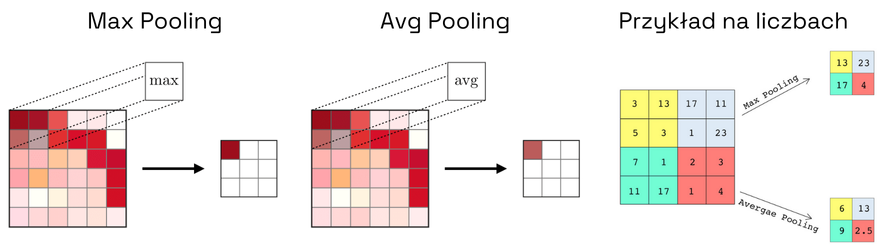

$$M(i, j) = \max_{(a, b) \in 𝒩} I(a, b) ← \text{max pooling} $$  
$$M(i, j) = \frac{1}{|𝒩|} \sum_{(a, b) \in 𝒩} I(a, b)  ← \text{avg pooling}$$

gdzie
- $I$ - wejściowy obrazek lub mapa
- $M$ - wyjściowa mapa
- $𝒩$ - fancy matematyczny znaczek na określenie sąsiedztwa, a w praktyce to zbiór wszystkich pozycji na wejściu $(a, b)$ które są aktualnie w rozważanym obszarze $n \times n$

#### Global Average Pooling

Ważną operacją bezpośrednio przydatną gdy będziemy implementować sieć CNN jest ekstremalna wersja poolingu, która przyjmuje mapę o wymiarze $H \times W \times C$ i zwraca wektor o długości $C$ (Tj. dla każdego kanału $c$ oblicza średnią po $H$ i $W$). Zwykle ta warstwa stanowi pomost między częścią konwolucyjną sieci a częścią w pełni połączoną (FFN).

### 5. Warstwa konwolucji w PyTorch
Zanim zaczniemy budować sieć składającą się z wielu warstw konwolucji, to warto zrozumieć jakie przyjmuje ona (najistotniejsze) parametry

```
class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```

- in_channels - liczba filtrów w wejściowej mapie/obrazku. Będzie to 3 dla obrazu RGB, a dla pośrednich map to będzie zależeć od liczby *out_channels* poprzedniej warstwy
- out_channels - liczba filtrów wyjściowych mapy (a jednocześnie liczba filtrów wejściowych do kolejnej warstwy konwolucyjnej)
- kernel_size - tuple (wysokość, szerokość) lub skalar dla kwadratowego filtra, od tej wielkości zależy też wysokość i szerokość wynikowej mapy
- stride - domyślnie 1, określa o ile pikseli przesuwamy się filtrem w każdym kolejnym kroku. Wybranie wartości > 1 ma podobny wpływ jak zastosowanie poolingu
- padding - domyślnie brak, określa jaka jest szerokość ramki, która jest dodawana do wejściowej mapy. Jest to przydatne kiedy chcemy, żeby wielkość wynikowej mapy była równa mapie wejściowej - wtedy podajemy jako wartość 'same' (tylko dla $stride = 1$)
- dilation - domyślnie 1, określa w obrębie samego filtra jaki jest odstęp między pikselami mapy wejściowej
- bias - oznacza to samo co dla warstwy liniowej, może być konieczne ustawienie na *False*

`kernel_size`, `stride`, `padding` i `dilation` mogą być typu `int` dla kwadratowych obszarów, lub `tuple` do określenia oddzielnie wysokości i szerokości

Wzór na wysokość ($H$) i szerokość ($W$) wyjściową ma postać
$$H_{out} = ⌊ \frac{H_{in} + 2 \times padding[0] - dilation[0] \times (kernel\_size[0] - 1) - 1}{stride[0]} + 1⌋$$

$$W_{out} = ⌊ \frac{W_{in} + 2 \times padding[1] - dilation[1] \times (kernel\_size[1] - 1) - 1}{stride[1]} + 1⌋$$

(symbol "podłogi" $⌊$, $⌋$ oznacza zaokrąglenie w dół do liczby całkowitej)

dla kwadratowego wejścia i filtrów upraszcza się to do $H_{out} = W_{out}$



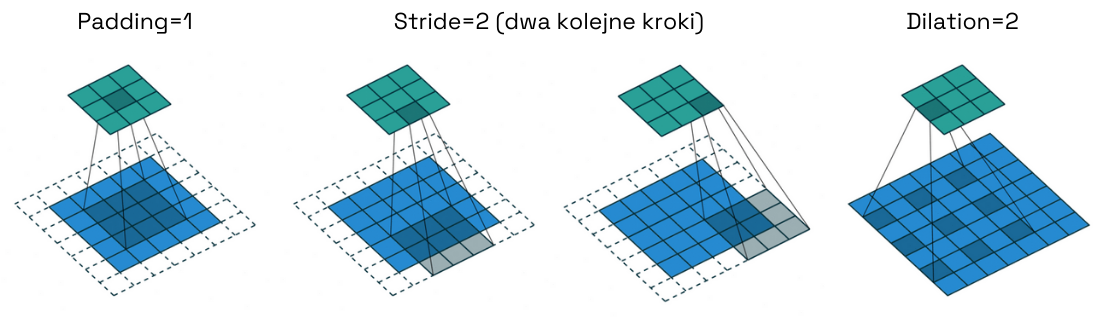

### Zadanie 2
Na podstawie wyżej wyjaśnionych argumentów i wzorów uzupełnij poniżej brakujące wartości. Nie musisz nad tym spędziać nie wiadomo ile czasu, ale warto nabrać intuicji które parametry musisz zmienić i jakie powinny być wartości by uzyskać zamierzoną wyjściową wielkość.

**Uwaga** zgodnie z konwencją Pytorcha, kolejność wymiarów po kolei to ($B$, $D$, $H$, $W$), tak więc wymiar kanału znajduje się nie na końcu, lecz na początku każdego obrazka/mapy. $B$ to batch size równy 1 tutaj.

In [ ]:
def validate_layer(case_name, layer, input_shape, expected_shape):
    print(f"--- {case_name} ---")
    print(f"Input: {input_shape}")

    # Tworzymy losowy tensor z batch=1
    x = torch.randn(1, *input_shape)

    try:
        y = layer(x)
        out_shape = tuple(y.shape)[1:] # bez batch

        print(f"Oczekiwany kształt: {expected_shape}")
        print(f"Twój kształt:       {out_shape}")

        if out_shape == expected_shape:
            print("OK. \n")
        else:
            print("Błąd: Kształty się nie zgadzają.\n")

    except Exception as e:
        print(f"Jakiś błąd: {e}\n")

# -------- TEST CASES ---------------

# PRZYPADEK 1: Agresywna redukcja (styl pierwszej warstwy AlexNet)
# Wejście: 224x224 (obraz)
# Wyjście: 55x55
# Wymagane: Użyj Padding=2. Resztę dobierz.
# Wskazówka: Kernel jest duży (>7), a krok (stride) też jest spory (>2).
case_1 = nn.Conv2d(
    in_channels=3,
    out_channels=64,
    padding=2,
    dilation=1,
    # --- DO UZUPEŁNIENIA ---
    kernel_size=11,  # <-- zmień to
    stride=4        # <-- zmień to
)


# Test 1
validate_layer("PRZYPADEK 1: Redukcja 224 -> 55", case_1,
                input_shape=(3, 224, 224),
                expected_shape=(64, 55, 55))

# PRZYPADEK 2: Asymetryczna konwolucja
# Wejście: 32x32
# Wyjście: 30x16
# Wymagane: Padding=0.
# Wskazówka: Wysokość (32->30) maleje wolno, Szerokość (32->16) maleje szybko.
# Użyj krotki (tuple) dla kernel_size i stride, np. (h, w).
case_2 = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    padding=0,
    dilation=1,
    # --- DO UZUPEŁNIENIA ---
    kernel_size=(3, 1), # <-- zmień to
    stride=(1, 2)       # <-- zmień to
)

# Test 2
validate_layer("PRZYPADEK 2: Prostokątne okna 32 -> 30x16", case_2,
                input_shape=(1, 32, 32),
                expected_shape=(1, 30, 16))


# PRZYPADEK 3: "Dziurawy" Kernel (Dilated Convolution)
# Wejście: 50x50
# Wyjście: 46x46
# Wymagane: Stride=1, Padding=0. Kernel ma rozmiar 3x3.
# Zastanów się jak to możliwe, że kernel (3, 3) zmniejsza wielkość aż o 4 piksele?
case_3 = nn.Conv2d(
    in_channels=16,
    out_channels=16,
    stride=1,
    padding=0,
    kernel_size=3,
    # --- DO UZUPEŁNIENIA ---
    dilation=2  # <-- zmień to
)


# Test 3
validate_layer("PRZYPADEK 3: Dylatacja 50 -> 46", case_3,
                input_shape=(16, 50, 50),
                expected_shape=(16, 46, 46))

--- PRZYPADEK 1: Redukcja 224 -> 55 ---
Input: (3, 224, 224)
Oczekiwany kształt: (64, 55, 55)
Twój kształt:       (64, 55, 55)
OK. 

--- PRZYPADEK 2: Prostokątne okna 32 -> 30x16 ---
Input: (1, 32, 32)
Oczekiwany kształt: (1, 30, 16)
Twój kształt:       (1, 30, 16)
OK. 

--- PRZYPADEK 3: Dylatacja 50 -> 46 ---
Input: (16, 50, 50)
Oczekiwany kształt: (16, 46, 46)
Twój kształt:       (16, 46, 46)
OK. 



### 6. Architektura sieci konwolucyjnej

Głębokie sieci konwolucyjne składają się z warstw konwolucyjnych przeplatanych funkcjami aktywacji (zwykle ReLU), operacjami Poolingu, oraz odpowiednikami w 2D Batch Normalization i Dropout (niekoniecznie w tej kolejności). Wraz z kolejnymi warstwami powinna rosnąć liczba filtrów (np. 16 -> 32 -> 64 -> 128 itp.) i zmniejszać się wielkość każdej wynikowej mapy (filtry mają zwykle rozmiar 3x3).

Po serii takich warstw musimy znowu wrócić do w pełni połączonych warstw, z tego powodu stosujemy Global Average Pooling. Typowo taka architektura posłuży do zadania klasyfikacji.  



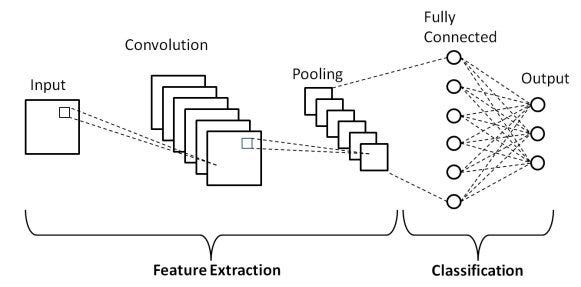

### Zadanie 3

**Zaimplementuj** i **wytrenuj** sieć konwolucyjną do zadania klasyfikacji dla zbioru FashionMNIST lub CIFAR10 (dowolność wyboru) która będzie zawierała następujące elementy
- co najmniej 2 bloki składające się z warstw konwolucyjnych i funkcji aktywacji
- sieci w pełni połączonej (minimalna głębokość to 1) służącej jako klasyfikator (powinno to być łatwe po poprzedniej liście)
- na tym etapie użyj [Flatten](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.flatten.Flatten.html) do spłaszczenia wymiarów $(B, C, H, W) → (B, C * H * W)$ dla wejścia do warswty liniowej

posłuży ona jako baseline do dalszych eksperymentów. Jeśli dysponujesz siecią FNN z poprzedniej listy, to możesz też odnieść się do jej wyników (nie musisz jej tutaj kopiować i na nowo trenować).

Przebieg trenowania dla sieci konwolucyjnej jest praktycznie taki sam jak do sieci z poprzedniego zadania, tylko że nie spłaszczamy obrazków na wejściu (m. in).

Przykładowy kod do pobrania danych (można go modyfikować):

```python
from torchvision import datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # lub użyjcie innej normalizacji jeśli uznacie za prawidłowe
  ])

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
```
**Zwizualizuj** krzywe uczenia tak jak na poprzednich listach i odpowiednie metryki (np. *f1-score* lub *accuracy*)

---
Pobranie potrzebnych modułów + modułu gdzie umieściłem kod z klasą treningową i funkcjami do tworzenia wykresów. Moduł `Helper_module` stanowi drobną modyfikację kodu z poprzedniego notatnika, lecz jego zawartość jest załączona razem z tym notatnikiem na GitHub.

In [ ]:
import math
from torch.optim.lr_scheduler import CosineAnnealingLR
import sys
sys.path.insert(0, "/content/drive/MyDrive/wdrozenie/modules")
import Helper_module as m # moduł z kodem do treningu i wizualizacji

In [ ]:
from torchvision import datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # lub użyjcie innej normalizacji jeśli uznacie za prawidłowe
  ])

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.58MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 30.8MB/s]


Utworzenie dataloaderów

In [ ]:
batch_size = 128
train_size = int(0.8 * len(trainset))
train_data, validation_data = torch.utils.data.random_split(trainset, [train_size, len(trainset) - train_size])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Klasa modelu CNN. Metoda `__init__` zawiera wszystkie przewidziane w planie eksperymentów warstwy. Wybrane warstwy takie jak batch norm, dropout czy pooling ustawiane są za pomocą odpowiednich parametrów. Dodatkowo, obliczany jest rozmiar obrazu (`img_length`) po przejściu przez kolejne warstwy konwolucyjne oraz poolingu w celu zdefiniowania odpowiedniej liczby wejść dla końcowej warstwy w pełni połączonej.

In [ ]:
class CNNmodel(nn.Module):

  def __init__(self, pooling=None, global_pooling=False, batch_norm=False, dropout=None, conv_layers_params=[
      (1, 4, 3, 1, 1, 1),
      (4, 8, 3, 1, 1, 1) # domyślne parametry
  ]):
    super().__init__()
    layers = [] # zainicjowanie listy warstw
    img_length = 28
    for params in conv_layers_params:
      # wersja podstawowa z warstwami konwolucyjnymi i ReLu
      layers.append(nn.Conv2d(in_channels=params[0], out_channels=params[1], kernel_size=params[2], stride=params[3], padding=params[4], dilation=params[5]))
      if batch_norm: # opcjonalne batch_norm
        layers.append(nn.BatchNorm2d(params[1]))
      layers.append(nn.ReLU())
      # wzór na obliczenie rozmiarów obrazu po konwolucji
      img_length = math.floor((img_length + 2 * params[4] - params[5] * (params[2] - 1) - 1) / params[3] + 1)

      # pooling
      if pooling == 'max': # max
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        img_length //= 2
      elif pooling == 'avg': # average
        layers.append(nn.AvgPool2d(kernel_size=2, stride=2))
        img_length //= 2

      # dropout
      if dropout is not None:
        layers.append(nn.Dropout2d(dropout))

    # global pooling/flatten
    linear_input = conv_layers_params[-1][1]*(img_length**2)
    if global_pooling:
      layers.append(nn.AdaptiveAvgPool2d((1, 1)))
      linear_input = conv_layers_params[-1][1] # liczba kanałów wyjściowych ostatniej warstwy konwolucyjnej

    layers.append(nn.Flatten())
    layers.append(nn.Linear(in_features=linear_input, out_features=10))
    # zapakowanie warstw do nn.Sequential, aby uprościć funkcję forward() poniżej
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    return self.layers(x)

Domyślna liczba epok.

In [ ]:
epochs_num = 50

Model bazowy. Jako że w poprzednim notatniku early stopping oraz scheduler okazały się bardzo przydatne to zdecydowałem się je tutaj dodać :)

  0%|          | 0/50 [00:00<?, ?it/s]

LR: 0.0010


  2%|▏         | 1/50 [00:22<18:41, 22.90s/it]

epoch: 1, train loss: 0.394, validation loss: 0.403


  4%|▍         | 2/50 [00:46<18:50, 23.55s/it]

LR: 0.0010


  6%|▌         | 3/50 [01:11<18:48, 24.02s/it]

LR: 0.0010
epoch: 3, train loss: 0.314, validation loss: 0.350


  8%|▊         | 4/50 [01:34<17:59, 23.48s/it]

LR: 0.0010


 10%|█         | 5/50 [01:57<17:29, 23.33s/it]

LR: 0.0010
epoch: 5, train loss: 0.267, validation loss: 0.319


 12%|█▏        | 6/50 [02:18<16:39, 22.72s/it]

LR: 0.0010


 14%|█▍        | 7/50 [02:41<16:22, 22.84s/it]

LR: 0.0010
epoch: 7, train loss: 0.240, validation loss: 0.304


 16%|█▌        | 8/50 [03:04<16:00, 22.87s/it]

LR: 0.0009


 18%|█▊        | 9/50 [03:26<15:20, 22.44s/it]

LR: 0.0009
epoch: 9, train loss: 0.206, validation loss: 0.284


 20%|██        | 10/50 [03:49<15:07, 22.68s/it]

LR: 0.0009


 22%|██▏       | 11/50 [04:11<14:33, 22.40s/it]

LR: 0.0009
epoch: 11, train loss: 0.187, validation loss: 0.279


 24%|██▍       | 12/50 [04:33<14:10, 22.38s/it]

LR: 0.0009


 26%|██▌       | 13/50 [04:56<13:58, 22.67s/it]

LR: 0.0009
epoch: 13, train loss: 0.176, validation loss: 0.281


 28%|██▊       | 14/50 [05:18<13:24, 22.34s/it]

LR: 0.0008


 30%|███       | 15/50 [05:41<13:10, 22.58s/it]

LR: 0.0008
epoch: 15, train loss: 0.168, validation loss: 0.283


 32%|███▏      | 16/50 [06:03<12:38, 22.30s/it]

LR: 0.0008


 34%|███▍      | 17/50 [06:25<12:18, 22.38s/it]

LR: 0.0008
epoch: 17, train loss: 0.157, validation loss: 0.286


 36%|███▌      | 18/50 [06:48<11:58, 22.45s/it]

LR: 0.0007


 38%|███▊      | 19/50 [07:09<11:26, 22.14s/it]

LR: 0.0007
epoch: 19, train loss: 0.157, validation loss: 0.297


 40%|████      | 20/50 [07:32<11:09, 22.33s/it]

LR: 0.0007


 42%|████▏     | 21/50 [07:54<10:40, 22.08s/it]

LR: 0.0007
epoch: 21, train loss: 0.143, validation loss: 0.296


 44%|████▍     | 22/50 [08:17<10:29, 22.47s/it]

LR: 0.0006


 46%|████▌     | 23/50 [08:40<10:07, 22.50s/it]

LR: 0.0006
epoch: 23, train loss: 0.142, validation loss: 0.301


 48%|████▊     | 24/50 [09:02<09:43, 22.46s/it]

LR: 0.0006


 50%|█████     | 25/50 [09:26<09:33, 22.94s/it]

LR: 0.0005
epoch: 25, train loss: 0.123, validation loss: 0.292


 50%|█████     | 25/50 [09:49<09:49, 23.56s/it]

LR: 0.0005
Early stopping at epoch 26


test loss: 0.321


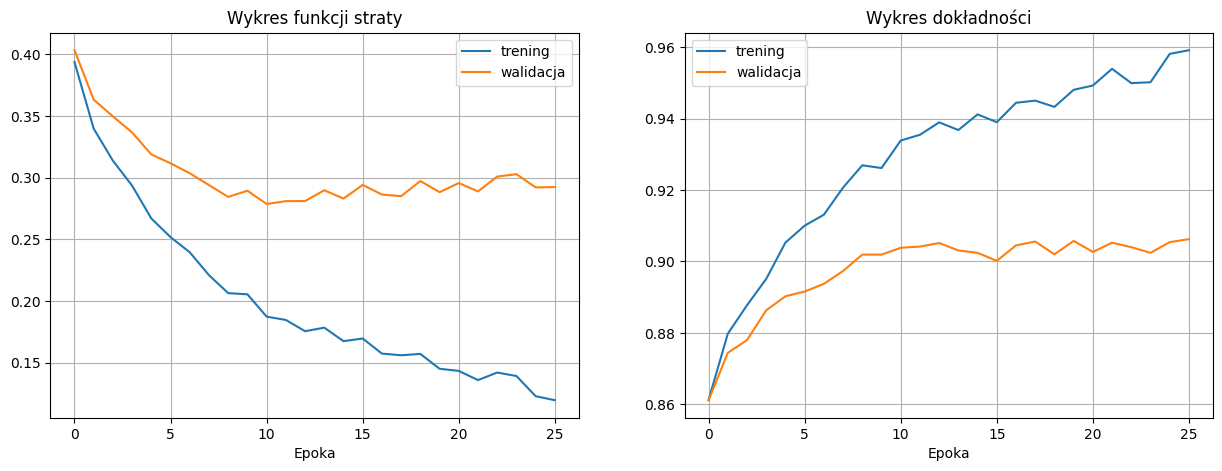

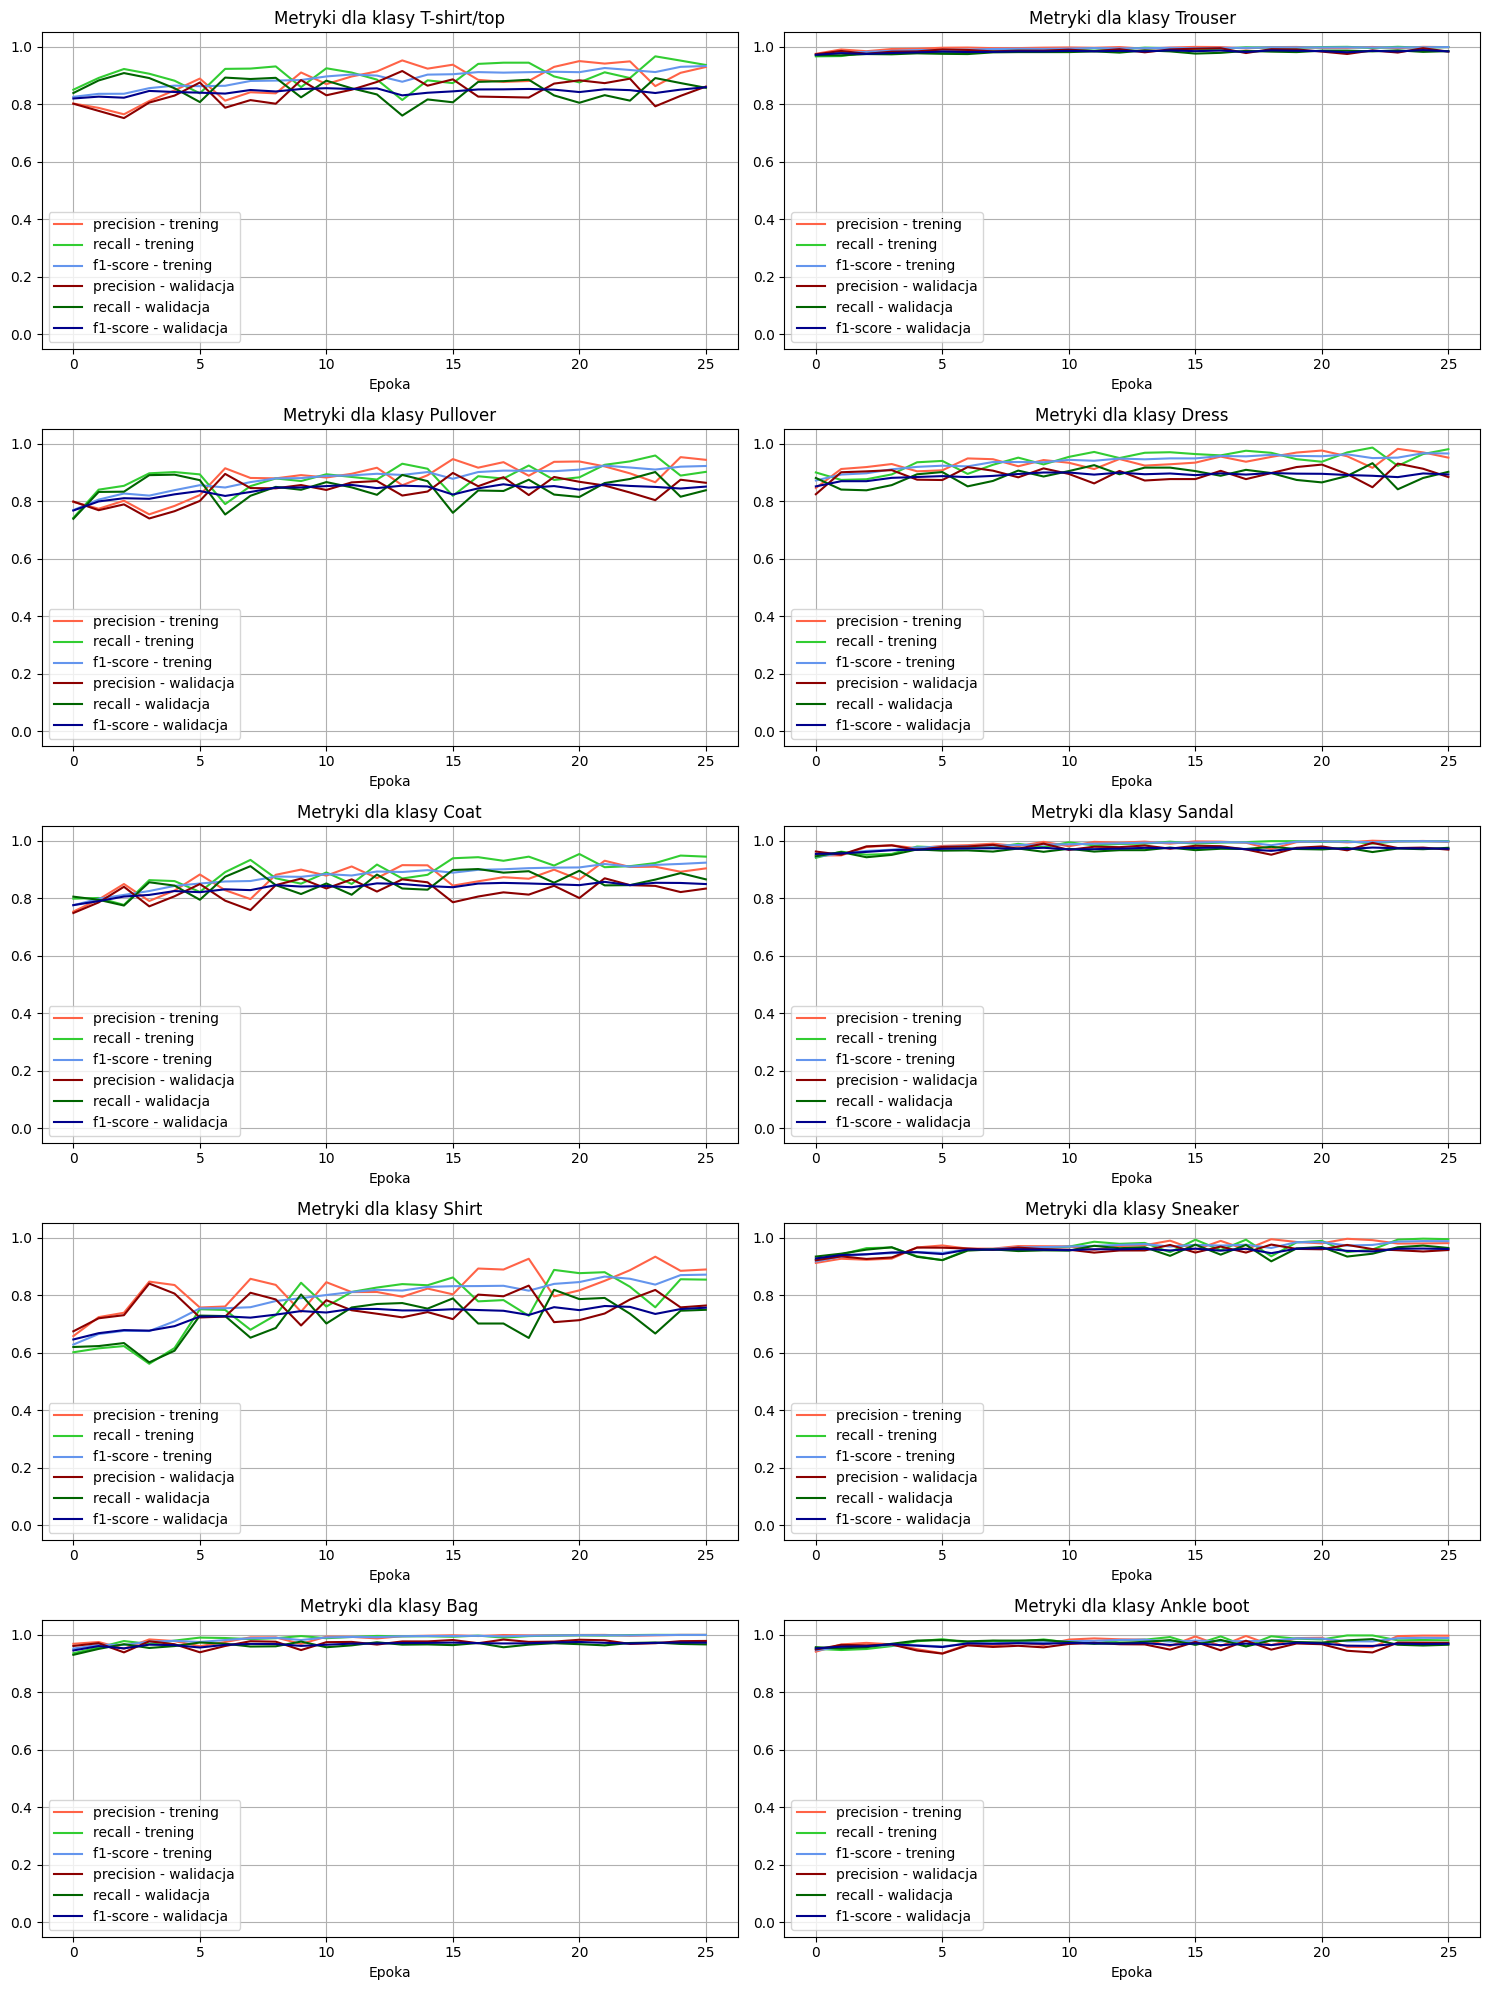

In [ ]:
cnn = CNNmodel()

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num, eta_min=0.0001)

trainer = m.TrainingClass(cnn, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler, patience=15)
tr_losses1, val_losses1, tr_metrics1, val_metrics1, tr_accuracies1, val_accuracies1 = trainer.training_loop(epochs_num, "cnn-base-model", trainloader, validationloader, testloader)

m.create_loss_and_accuracy_plot(tr_losses1, val_losses1, tr_accuracies1, val_accuracies1)
m.create_metrics_plot(tr_metrics1, val_metrics1)

Powyższe wizualizacje wskazują na całkiem dobre działanie modelu. Porównując z poprzednim notatnikiem, wyniki są porównywalne, przy czym model CNN osiągnął je przy zdecydowanie mniejszej liczbie parametrów co widać poniżej. W przypadku mojej sieci w pełni połączonej, która w pierwszej ukrytej warstwie miała 100 neuronów, tworzyło to prawie 80000 wag dla tylko pierwszej warstwy (28x28x100), podczas gdy tutaj cały model CNN zbudowany jest tylko z 63000 parametrów.

In [ ]:
summary(cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNmodel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─Conv2d: 2-3                       [1, 8, 28, 28]            296
│    └─ReLU: 2-4                         [1, 8, 28, 28]            --
│    └─Flatten: 2-5                      [1, 6272]                 --
│    └─Linear: 2-6                       [1, 10]                   62,730
Total params: 63,066
Trainable params: 63,066
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.33
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.25
Estimated Total Size (MB): 0.33

### Zadanie 4

Przeprowadź następujące eksperymenty:

- Eksperyment 1: Dodaj *Max Pooling* w odpowiednim miejscu po warstwach konwolucyjnych. Porównaj z działaniem *Average Pooling*.

- Eksperyment 2: Dodaj warstwę *Global Average Pooling* zamiast spłaszczania tensora przy pomocy Flatten. (Bazuj na sieci z eksperymentu 1)

- Eksperyment 3: Dodaj *Batch Normalization* i/lub *Dropout* w wersji dla 2D. (Bazuj na sieci z eksperymentu 2 z Max Poolingiem)

- Eksperyment 4: Zwiększ liczbę warstw konwolucyjnych i odpowiednio dobierz liczbę filtrów. (Bazuj na sieci z eksperymentu 3)

- Eksperyment 5: Zmień co najmniej 2 wartości domyślne parametrów z listy: `stride`, `dilation`, `padding`. Dlaczego wybrałeś/aś takie parametry i jak poskutkowało ich dodanie? (np. sieć jest mniejsza; wynikowa mapa przed global avg pooling jest mniejsza;)

Po każdej nowej wersji modelu zbadaj jego wielkość

```
summary(model, input_size=(1, 3, 32, 32)) # model to instancja sieci, a obrazki są np. 1x28x28 (MNIST) lub 3x32x32 (CIFAR)
```

Pamiętaj, żeby nie pisać na nowo (bądź kopiować) pętli do trenowania - zwiększy to czytelność notebooka. Również może być pomocna parametryzacja modelu zamiast tworzenie nowej klasy dla każdego eksperymentu z osobna ([ModuleList](https://docs.pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) łączy warstwy w liście wejściowej). **Udokumentuj przebieg eksperymentów** w postaci porównania wybranych metryk i/lub krzywych uczenia.


# Eksperymenty z poolingiem

Przeprowadzone niżej eksperymenty pokazują, że zastosowanie poolingu minimalnie pogorszyło wyniki treningu (1~2% mniejsza dokładność i nieznaczny wzrost straty [patrząc po zbiorze walidacyjnym]). Z drugiej strony zdecydowanie zmalała różnica wyników pomiędzy zbiorem treningowym a walidacyjnym, co zobaczyć można po funkcji straty oraz wykresach metryk dla klas o najsłabszych wynikach np. `Shirt`. Wskazuje to na lepszą generalizację podczas uczenia. Dodatkowo wyświetlenie podsumowania modelu pokazuje, że zmniejszył się przy tym rozmiar modelu. Modele z zastosowanym poolingiem zajmują ponad 5-krotnie mniej pamięci a liczba samych parametrów zmalała około 15-krotnie.
<br>
Zarówno max jak i średni pooling osiągają w przypadku datasetu MNIST porównywalne wyniki, jednak w dalszych eksperymentach wykorzystany będzie max ze względu na instrukcję do eksperymentów opisaną powyżej.

  2%|▏         | 1/50 [00:23<19:12, 23.52s/it]

LR: 0.0010
epoch: 1, train loss: 0.523, validation loss: 0.522


  4%|▍         | 2/50 [00:45<18:04, 22.59s/it]

LR: 0.0010


  6%|▌         | 3/50 [01:08<17:58, 22.95s/it]

LR: 0.0010
epoch: 3, train loss: 0.427, validation loss: 0.435


  8%|▊         | 4/50 [01:32<17:43, 23.12s/it]

LR: 0.0010


 10%|█         | 5/50 [01:54<17:03, 22.75s/it]

LR: 0.0010
epoch: 5, train loss: 0.383, validation loss: 0.390


 12%|█▏        | 6/50 [02:17<16:53, 23.03s/it]

LR: 0.0010


 14%|█▍        | 7/50 [02:40<16:28, 22.99s/it]

LR: 0.0010
epoch: 7, train loss: 0.366, validation loss: 0.377


 16%|█▌        | 8/50 [03:03<15:55, 22.76s/it]

LR: 0.0009


 18%|█▊        | 9/50 [03:26<15:47, 23.10s/it]

LR: 0.0009
epoch: 9, train loss: 0.340, validation loss: 0.356


 20%|██        | 10/50 [03:49<15:19, 22.98s/it]

LR: 0.0009


 22%|██▏       | 11/50 [04:12<14:52, 22.88s/it]

LR: 0.0009
epoch: 11, train loss: 0.327, validation loss: 0.347


 24%|██▍       | 12/50 [04:36<14:39, 23.15s/it]

LR: 0.0009


 26%|██▌       | 13/50 [04:59<14:17, 23.17s/it]

LR: 0.0009
epoch: 13, train loss: 0.328, validation loss: 0.350


 28%|██▊       | 14/50 [05:22<13:53, 23.16s/it]

LR: 0.0008


 30%|███       | 15/50 [05:46<13:35, 23.30s/it]

LR: 0.0008
epoch: 15, train loss: 0.321, validation loss: 0.346


 32%|███▏      | 16/50 [06:08<13:05, 23.11s/it]

LR: 0.0008


 34%|███▍      | 17/50 [06:31<12:43, 23.14s/it]

LR: 0.0008
epoch: 17, train loss: 0.317, validation loss: 0.344


 36%|███▌      | 18/50 [06:55<12:24, 23.27s/it]

LR: 0.0007


 38%|███▊      | 19/50 [07:17<11:52, 22.97s/it]

LR: 0.0007
epoch: 19, train loss: 0.304, validation loss: 0.333


 40%|████      | 20/50 [07:41<11:32, 23.09s/it]

LR: 0.0007


 42%|████▏     | 21/50 [08:04<11:12, 23.18s/it]

LR: 0.0007
epoch: 21, train loss: 0.295, validation loss: 0.327


 44%|████▍     | 22/50 [08:26<10:40, 22.89s/it]

LR: 0.0006


 46%|████▌     | 23/50 [08:50<10:25, 23.16s/it]

LR: 0.0006
epoch: 23, train loss: 0.288, validation loss: 0.320


 48%|████▊     | 24/50 [09:14<10:04, 23.27s/it]

LR: 0.0006


 50%|█████     | 25/50 [09:36<09:32, 22.89s/it]

LR: 0.0005
epoch: 25, train loss: 0.287, validation loss: 0.321


 52%|█████▏    | 26/50 [09:59<09:14, 23.12s/it]

LR: 0.0005


 54%|█████▍    | 27/50 [10:23<08:53, 23.20s/it]

LR: 0.0005
epoch: 27, train loss: 0.288, validation loss: 0.323


 56%|█████▌    | 28/50 [10:44<08:21, 22.79s/it]

LR: 0.0005


 58%|█████▊    | 29/50 [11:08<08:02, 22.99s/it]

LR: 0.0004
epoch: 29, train loss: 0.282, validation loss: 0.320


 60%|██████    | 30/50 [11:31<07:37, 22.90s/it]

LR: 0.0004


 62%|██████▏   | 31/50 [11:53<07:11, 22.74s/it]

LR: 0.0004
epoch: 31, train loss: 0.283, validation loss: 0.321


 64%|██████▍   | 32/50 [12:16<06:51, 22.88s/it]

LR: 0.0004


 66%|██████▌   | 33/50 [12:38<06:24, 22.61s/it]

LR: 0.0003
epoch: 33, train loss: 0.280, validation loss: 0.317


 68%|██████▊   | 34/50 [13:02<06:05, 22.87s/it]

LR: 0.0003


 70%|███████   | 35/50 [13:25<05:44, 22.99s/it]

LR: 0.0003
epoch: 35, train loss: 0.279, validation loss: 0.319


 72%|███████▏  | 36/50 [13:47<05:17, 22.68s/it]

LR: 0.0003


 74%|███████▍  | 37/50 [14:10<04:57, 22.92s/it]

LR: 0.0002
epoch: 37, train loss: 0.275, validation loss: 0.315


 76%|███████▌  | 38/50 [14:33<04:35, 22.94s/it]

LR: 0.0002


 78%|███████▊  | 39/50 [14:56<04:11, 22.83s/it]

LR: 0.0002
epoch: 39, train loss: 0.274, validation loss: 0.315


 80%|████████  | 40/50 [15:19<03:47, 22.79s/it]

LR: 0.0002


 82%|████████▏ | 41/50 [15:40<03:20, 22.27s/it]

LR: 0.0002
epoch: 41, train loss: 0.272, validation loss: 0.314


 84%|████████▍ | 42/50 [16:02<02:59, 22.43s/it]

LR: 0.0002


 86%|████████▌ | 43/50 [16:24<02:34, 22.11s/it]

LR: 0.0001
epoch: 43, train loss: 0.271, validation loss: 0.314


 88%|████████▊ | 44/50 [16:47<02:13, 22.30s/it]

LR: 0.0001


 90%|█████████ | 45/50 [17:09<01:52, 22.48s/it]

LR: 0.0001
epoch: 45, train loss: 0.270, validation loss: 0.312


 92%|█████████▏| 46/50 [17:32<01:30, 22.60s/it]

LR: 0.0001


 94%|█████████▍| 47/50 [17:56<01:08, 22.97s/it]

LR: 0.0001
epoch: 47, train loss: 0.273, validation loss: 0.314


 96%|█████████▌| 48/50 [18:20<00:46, 23.29s/it]

LR: 0.0001


 98%|█████████▊| 49/50 [18:42<00:22, 23.00s/it]

LR: 0.0001
epoch: 49, train loss: 0.271, validation loss: 0.315


100%|██████████| 50/50 [19:06<00:00, 22.94s/it]

LR: 0.0001


test loss: 0.333


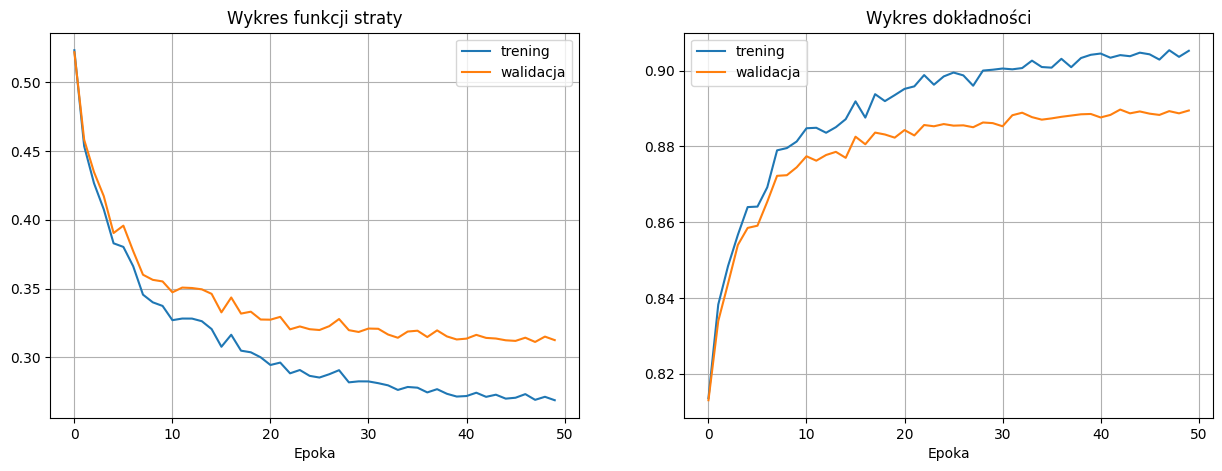

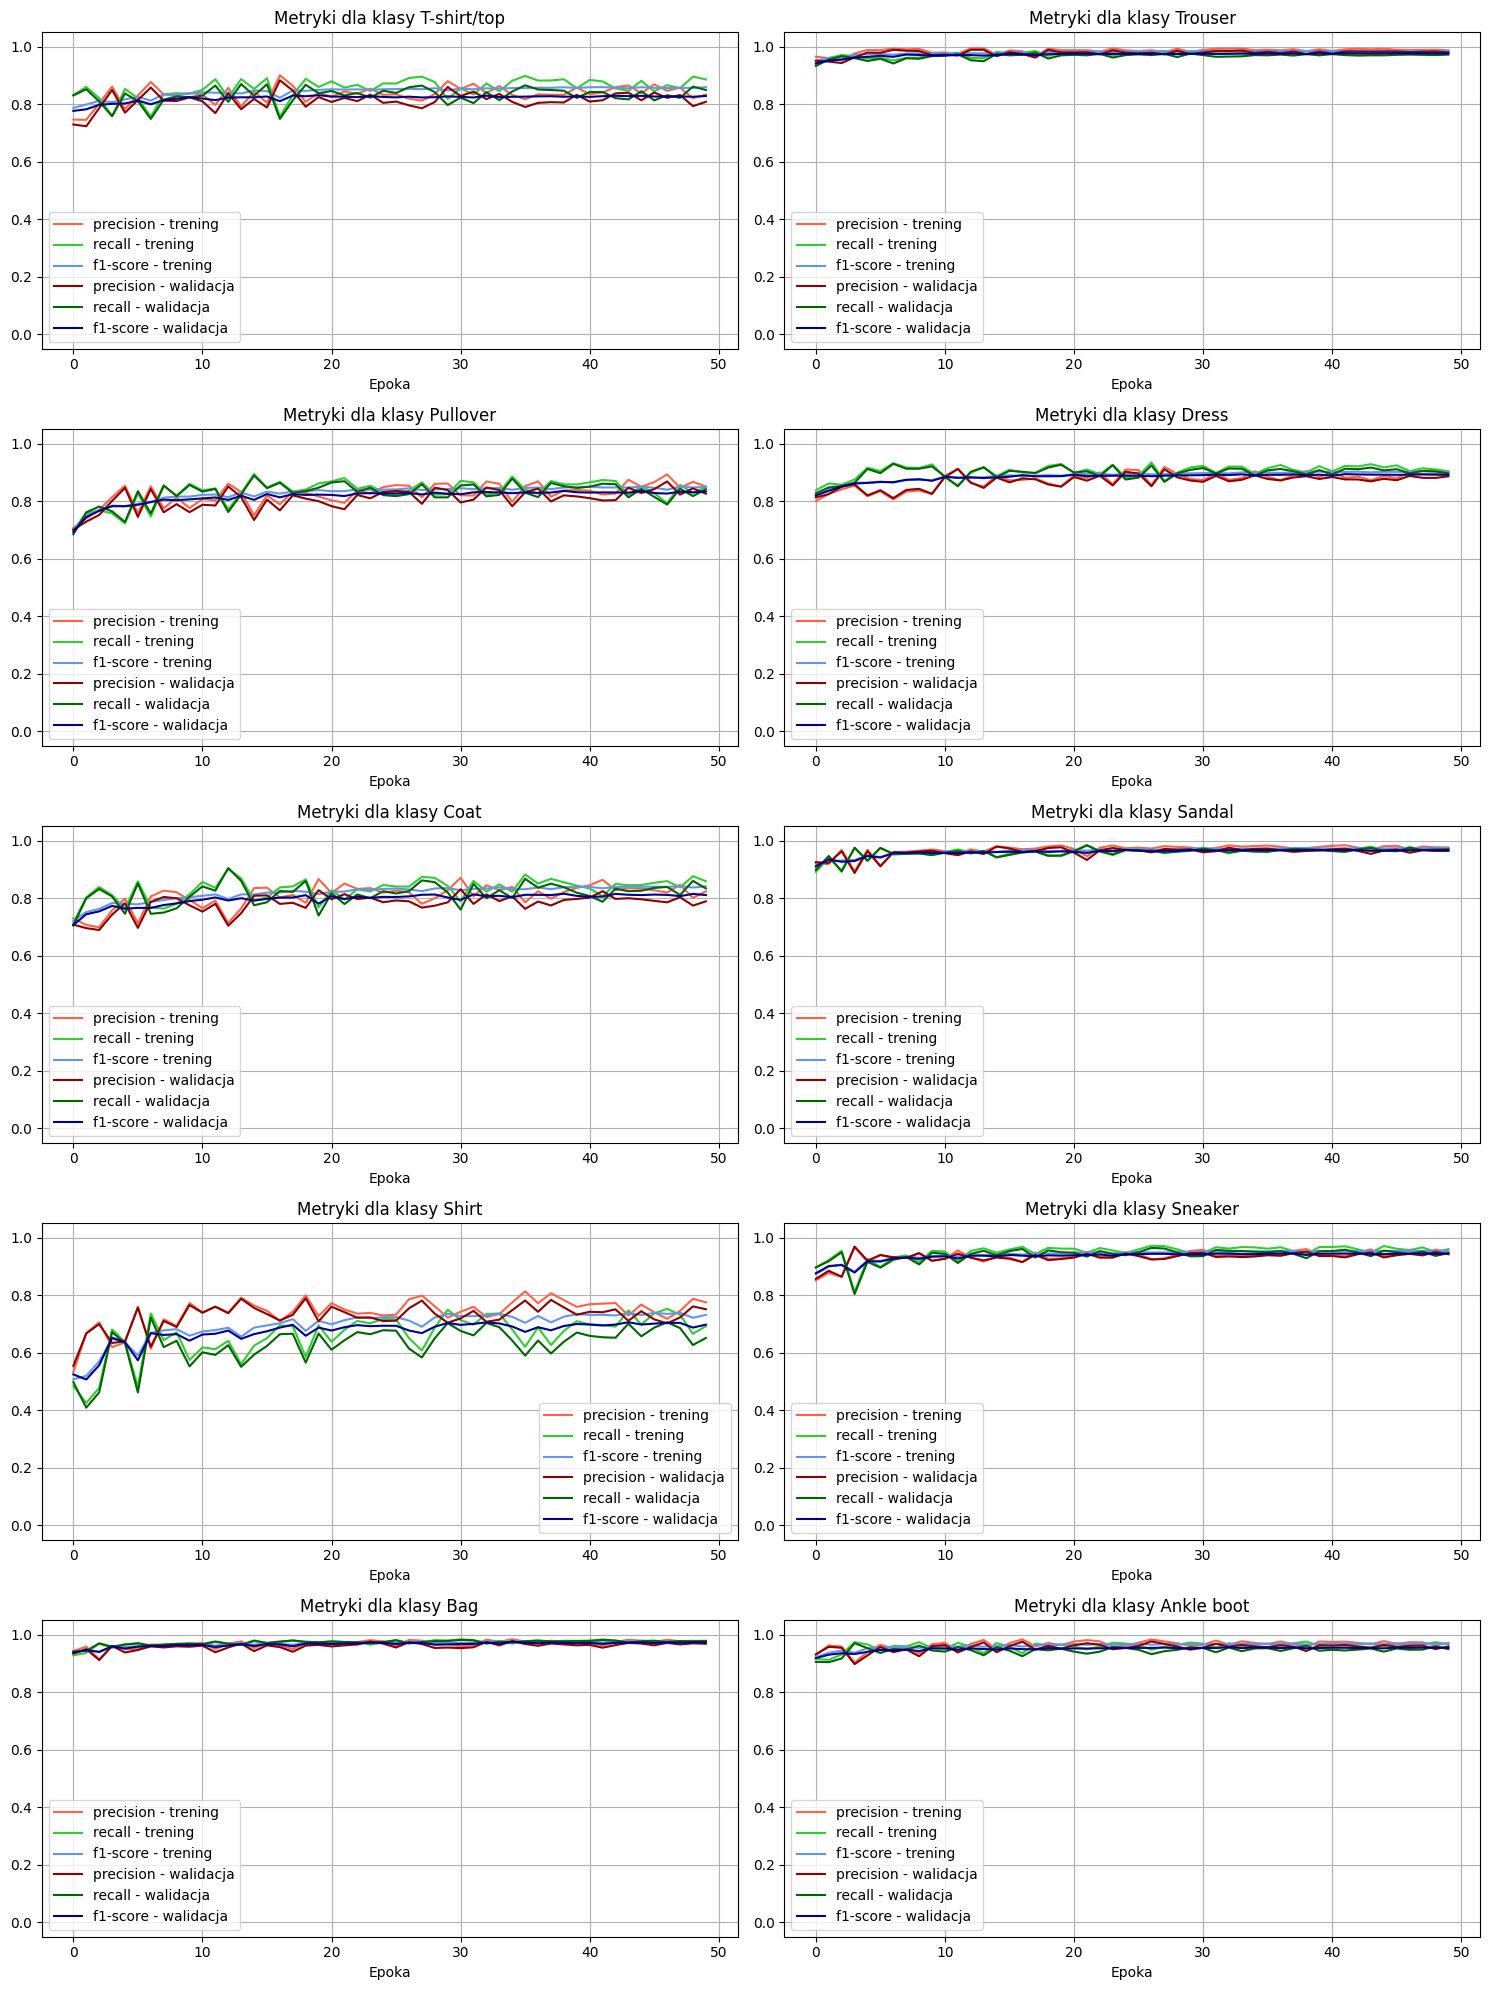

In [ ]:
# max pooling
cnn = CNNmodel(pooling='max')

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num, eta_min=0.0001)

trainer = m.TrainingClass(cnn, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler, patience=15)
tr_losses1, val_losses1, tr_metrics1, val_metrics1, tr_accuracies1, val_accuracies1 = trainer.training_loop(epochs_num, "cnn-max-pool", trainloader, validationloader, testloader)

m.create_loss_and_accuracy_plot(tr_losses1, val_losses1, tr_accuracies1, val_accuracies1)
m.create_metrics_plot(tr_metrics1, val_metrics1)

In [ ]:
summary(cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNmodel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 4, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 8, 14, 14]            296
│    └─ReLU: 2-5                         [1, 8, 14, 14]            --
│    └─MaxPool2d: 2-6                    [1, 8, 7, 7]              --
│    └─Flatten: 2-7                      [1, 392]                  --
│    └─Linear: 2-8                       [1, 10]                   3,930
Total params: 4,266
Trainable params: 4,266
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.0

  2%|▏         | 1/50 [00:22<18:08, 22.21s/it]

LR: 0.0010
epoch: 1, train loss: 0.597, validation loss: 0.600


  4%|▍         | 2/50 [00:45<18:30, 23.14s/it]

LR: 0.0010


  6%|▌         | 3/50 [01:09<18:15, 23.32s/it]

LR: 0.0010
epoch: 3, train loss: 0.480, validation loss: 0.483


  8%|▊         | 4/50 [01:31<17:32, 22.87s/it]

LR: 0.0010


 10%|█         | 5/50 [01:55<17:20, 23.12s/it]

LR: 0.0010
epoch: 5, train loss: 0.439, validation loss: 0.445


 12%|█▏        | 6/50 [02:18<17:04, 23.29s/it]

LR: 0.0010


 14%|█▍        | 7/50 [02:41<16:24, 22.90s/it]

LR: 0.0010
epoch: 7, train loss: 0.419, validation loss: 0.425


 16%|█▌        | 8/50 [03:04<16:12, 23.15s/it]

LR: 0.0009


 18%|█▊        | 9/50 [03:28<15:58, 23.38s/it]

LR: 0.0009
epoch: 9, train loss: 0.394, validation loss: 0.406


 20%|██        | 10/50 [03:51<15:24, 23.11s/it]

LR: 0.0009


 22%|██▏       | 11/50 [04:17<15:42, 24.16s/it]

LR: 0.0009
epoch: 11, train loss: 0.380, validation loss: 0.392


 24%|██▍       | 12/50 [04:40<15:05, 23.84s/it]

LR: 0.0009


 26%|██▌       | 13/50 [05:02<14:17, 23.18s/it]

LR: 0.0009
epoch: 13, train loss: 0.368, validation loss: 0.385


 28%|██▊       | 14/50 [05:26<14:04, 23.46s/it]

LR: 0.0008


 30%|███       | 15/50 [05:49<13:41, 23.47s/it]

LR: 0.0008
epoch: 15, train loss: 0.356, validation loss: 0.372


 32%|███▏      | 16/50 [06:11<13:00, 22.95s/it]

LR: 0.0008


 34%|███▍      | 17/50 [06:35<12:42, 23.09s/it]

LR: 0.0008
epoch: 17, train loss: 0.344, validation loss: 0.363


 36%|███▌      | 18/50 [06:58<12:20, 23.14s/it]

LR: 0.0007


 38%|███▊      | 19/50 [07:20<11:44, 22.73s/it]

LR: 0.0007
epoch: 19, train loss: 0.336, validation loss: 0.355


 40%|████      | 20/50 [07:43<11:27, 22.92s/it]

LR: 0.0007


 42%|████▏     | 21/50 [08:06<11:02, 22.83s/it]

LR: 0.0007
epoch: 21, train loss: 0.329, validation loss: 0.348


 44%|████▍     | 22/50 [08:28<10:38, 22.81s/it]

LR: 0.0006


 46%|████▌     | 23/50 [08:52<10:20, 22.98s/it]

LR: 0.0006
epoch: 23, train loss: 0.322, validation loss: 0.343


 48%|████▊     | 24/50 [09:14<09:49, 22.66s/it]

LR: 0.0006


 50%|█████     | 25/50 [09:37<09:30, 22.83s/it]

LR: 0.0005
epoch: 25, train loss: 0.323, validation loss: 0.344


 52%|█████▏    | 26/50 [10:00<09:10, 22.95s/it]

LR: 0.0005


 54%|█████▍    | 27/50 [10:22<08:38, 22.56s/it]

LR: 0.0005
epoch: 27, train loss: 0.313, validation loss: 0.336


 56%|█████▌    | 28/50 [10:45<08:21, 22.77s/it]

LR: 0.0005


 58%|█████▊    | 29/50 [11:08<08:00, 22.87s/it]

LR: 0.0004
epoch: 29, train loss: 0.306, validation loss: 0.329


 60%|██████    | 30/50 [11:30<07:33, 22.69s/it]

LR: 0.0004


 62%|██████▏   | 31/50 [11:54<07:15, 22.93s/it]

LR: 0.0004
epoch: 31, train loss: 0.305, validation loss: 0.328


 64%|██████▍   | 32/50 [12:16<06:49, 22.75s/it]

LR: 0.0004


 66%|██████▌   | 33/50 [12:40<06:30, 22.96s/it]

LR: 0.0003
epoch: 33, train loss: 0.307, validation loss: 0.330


 68%|██████▊   | 34/50 [13:04<06:11, 23.24s/it]

LR: 0.0003


 70%|███████   | 35/50 [13:26<05:45, 23.03s/it]

LR: 0.0003
epoch: 35, train loss: 0.299, validation loss: 0.324


 72%|███████▏  | 36/50 [13:50<05:25, 23.24s/it]

LR: 0.0003


 74%|███████▍  | 37/50 [14:14<05:04, 23.39s/it]

LR: 0.0002
epoch: 37, train loss: 0.297, validation loss: 0.323


 76%|███████▌  | 38/50 [14:36<04:37, 23.11s/it]

LR: 0.0002


 78%|███████▊  | 39/50 [15:00<04:15, 23.26s/it]

LR: 0.0002
epoch: 39, train loss: 0.297, validation loss: 0.322


 80%|████████  | 40/50 [15:24<03:54, 23.44s/it]

LR: 0.0002


 82%|████████▏ | 41/50 [15:46<03:27, 23.05s/it]

LR: 0.0002
epoch: 41, train loss: 0.295, validation loss: 0.322


 84%|████████▍ | 42/50 [16:10<03:06, 23.33s/it]

LR: 0.0002


 86%|████████▌ | 43/50 [16:33<02:43, 23.40s/it]

LR: 0.0001
epoch: 43, train loss: 0.295, validation loss: 0.322


 88%|████████▊ | 44/50 [16:56<02:18, 23.09s/it]

LR: 0.0001


 90%|█████████ | 45/50 [17:19<01:55, 23.10s/it]

LR: 0.0001
epoch: 45, train loss: 0.294, validation loss: 0.320


 92%|█████████▏| 46/50 [17:42<01:32, 23.08s/it]

LR: 0.0001


 94%|█████████▍| 47/50 [18:03<01:07, 22.65s/it]

LR: 0.0001
epoch: 47, train loss: 0.291, validation loss: 0.319


 96%|█████████▌| 48/50 [18:27<00:45, 22.86s/it]

LR: 0.0001


 98%|█████████▊| 49/50 [18:49<00:22, 22.72s/it]

LR: 0.0001
epoch: 49, train loss: 0.291, validation loss: 0.317


100%|██████████| 50/50 [19:12<00:00, 23.05s/it]

LR: 0.0001


test loss: 0.340


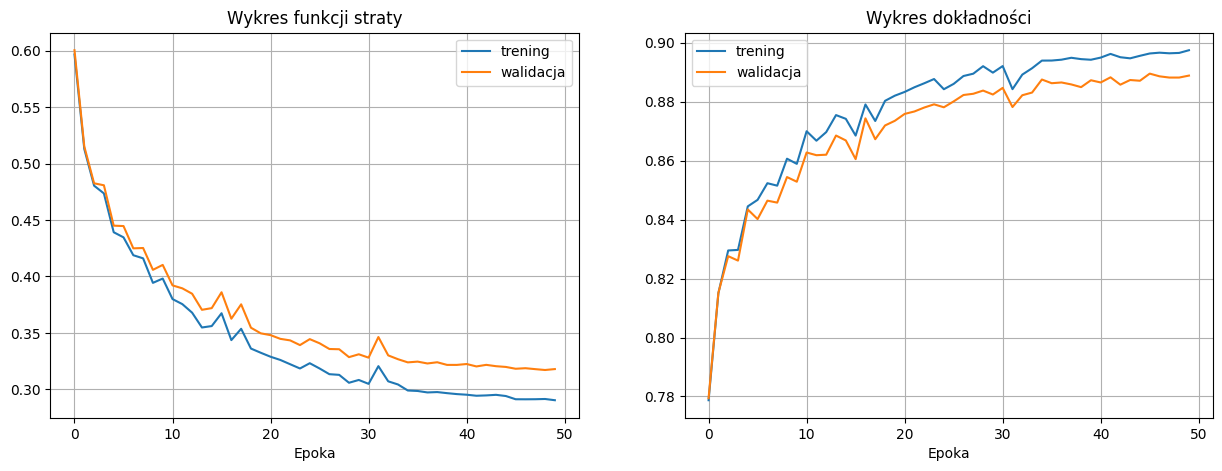

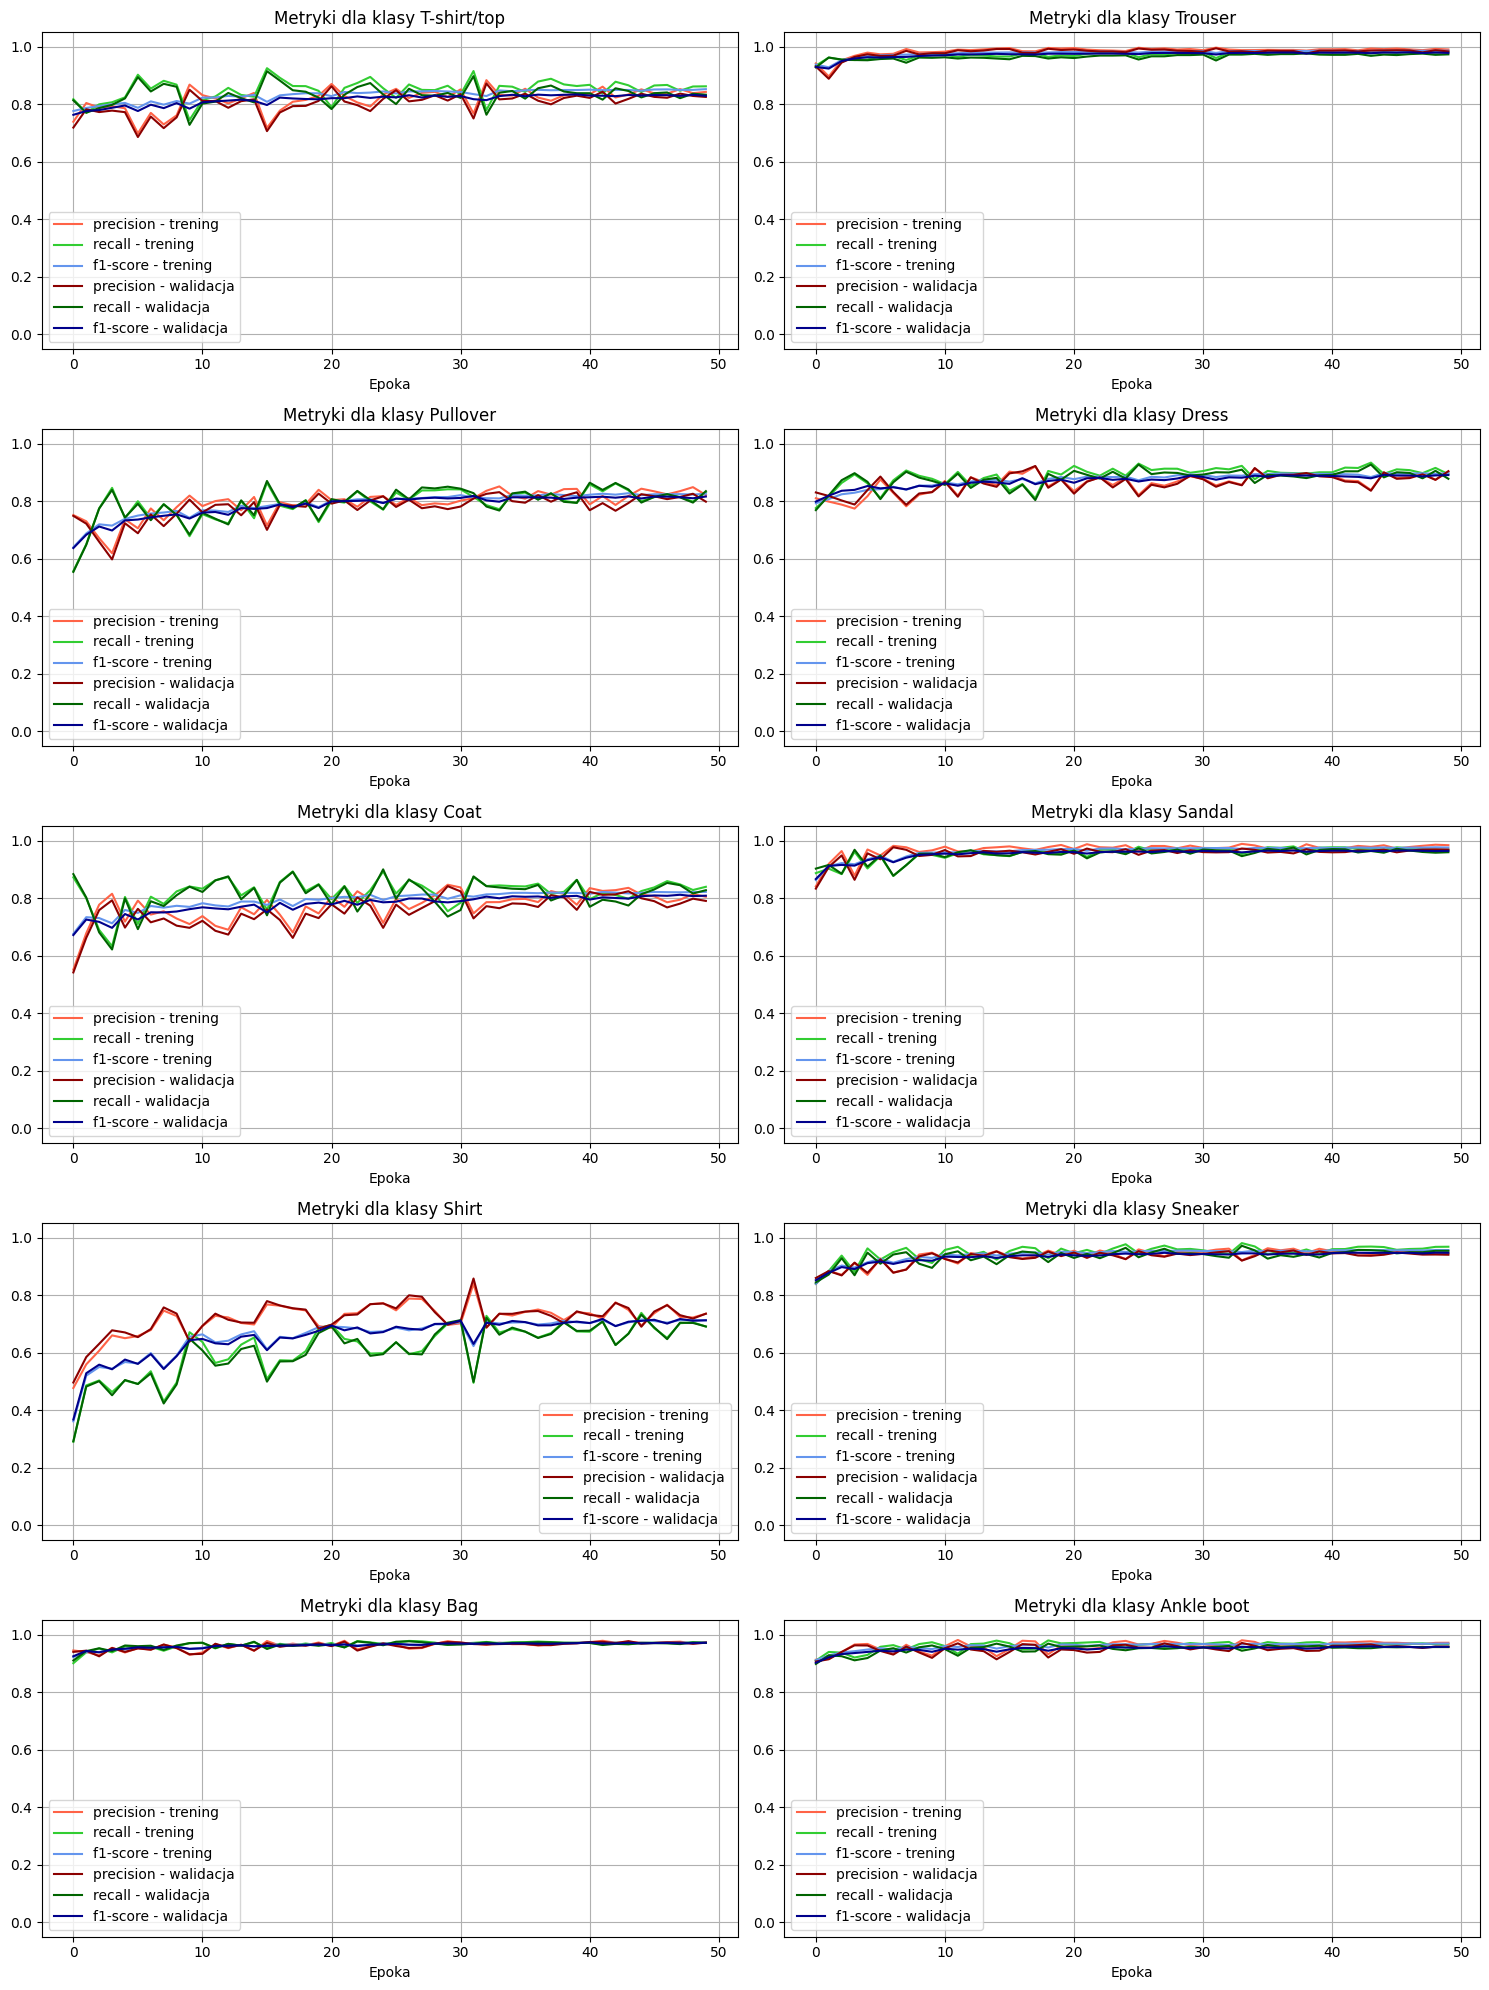

In [ ]:
# average pooling
cnn = CNNmodel(pooling='avg')

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num, eta_min=0.0001)

trainer = m.TrainingClass(cnn, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler, patience=15)
tr_losses1, val_losses1, tr_metrics1, val_metrics1, tr_accuracies1, val_accuracies1 = trainer.training_loop(epochs_num, "cnn-avg-pool", trainloader, validationloader, testloader)

m.create_loss_and_accuracy_plot(tr_losses1, val_losses1, tr_accuracies1, val_accuracies1)
m.create_metrics_plot(tr_metrics1, val_metrics1)

In [ ]:
summary(cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNmodel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─AvgPool2d: 2-3                    [1, 4, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 8, 14, 14]            296
│    └─ReLU: 2-5                         [1, 8, 14, 14]            --
│    └─AvgPool2d: 2-6                    [1, 8, 7, 7]              --
│    └─Flatten: 2-7                      [1, 392]                  --
│    └─Linear: 2-8                       [1, 10]                   3,930
Total params: 4,266
Trainable params: 4,266
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.0

# Eksperyment z global pooling

Po dodaniu do sieci globalnego poolingu ogólne wyniki modelu pogorszyły się, co zauważyć można po niższych metrykach oraz większej funkcji straty. Z drugiej strony różnica pomiędzy wynikami dla zbioru treningowego i walidacyjnego jest minimalna, co świadczyć może o lepszej generalizacji podczas treningu tego modelu. Dodatkowo, wyświetlone niżej podsumowanie pokazuje, że liczba parametrów modelu spadła aż 10-krotnie, natomiast cały model zajmuje około 50% mniej pamięci.

  2%|▏         | 1/50 [00:23<19:19, 23.66s/it]

LR: 0.0010
epoch: 1, train loss: 1.602, validation loss: 1.609


  4%|▍         | 2/50 [00:48<19:25, 24.28s/it]

LR: 0.0010


  6%|▌         | 3/50 [01:11<18:31, 23.65s/it]

LR: 0.0010
epoch: 3, train loss: 1.274, validation loss: 1.285


  8%|▊         | 4/50 [01:34<18:00, 23.49s/it]

LR: 0.0010


 10%|█         | 5/50 [01:58<17:41, 23.59s/it]

LR: 0.0010
epoch: 5, train loss: 1.118, validation loss: 1.125


 12%|█▏        | 6/50 [02:21<17:05, 23.32s/it]

LR: 0.0010


 14%|█▍        | 7/50 [02:44<16:40, 23.26s/it]

LR: 0.0010
epoch: 7, train loss: 1.049, validation loss: 1.060


 16%|█▌        | 8/50 [03:08<16:25, 23.46s/it]

LR: 0.0009


 18%|█▊        | 9/50 [03:31<15:55, 23.29s/it]

LR: 0.0009
epoch: 9, train loss: 0.997, validation loss: 1.008


 20%|██        | 10/50 [03:54<15:30, 23.26s/it]

LR: 0.0009


 22%|██▏       | 11/50 [04:18<15:15, 23.48s/it]

LR: 0.0009
epoch: 11, train loss: 0.951, validation loss: 0.962


 24%|██▍       | 12/50 [04:41<14:45, 23.31s/it]

LR: 0.0009


 26%|██▌       | 13/50 [05:04<14:21, 23.28s/it]

LR: 0.0009
epoch: 13, train loss: 0.930, validation loss: 0.940


 28%|██▊       | 14/50 [05:28<14:02, 23.41s/it]

LR: 0.0008


 30%|███       | 15/50 [05:51<13:37, 23.36s/it]

LR: 0.0008
epoch: 15, train loss: 0.910, validation loss: 0.921


 32%|███▏      | 16/50 [06:14<13:11, 23.29s/it]

LR: 0.0008


 34%|███▍      | 17/50 [06:39<13:05, 23.80s/it]

LR: 0.0008
epoch: 17, train loss: 0.901, validation loss: 0.912


 36%|███▌      | 18/50 [07:03<12:46, 23.95s/it]

LR: 0.0007


 38%|███▊      | 19/50 [07:26<12:13, 23.67s/it]

LR: 0.0007
epoch: 19, train loss: 0.883, validation loss: 0.894


 40%|████      | 20/50 [07:51<11:56, 23.89s/it]

LR: 0.0007


 42%|████▏     | 21/50 [08:15<11:36, 24.02s/it]

LR: 0.0007
epoch: 21, train loss: 0.873, validation loss: 0.883


 44%|████▍     | 22/50 [08:38<11:05, 23.78s/it]

LR: 0.0006


 46%|████▌     | 23/50 [09:01<10:36, 23.57s/it]

LR: 0.0006
epoch: 23, train loss: 0.859, validation loss: 0.869


 48%|████▊     | 24/50 [09:25<10:14, 23.65s/it]

LR: 0.0006


 50%|█████     | 25/50 [09:49<09:51, 23.65s/it]

LR: 0.0005
epoch: 25, train loss: 0.851, validation loss: 0.860


 52%|█████▏    | 26/50 [10:12<09:24, 23.53s/it]

LR: 0.0005


 54%|█████▍    | 27/50 [10:36<09:05, 23.73s/it]

LR: 0.0005
epoch: 27, train loss: 0.844, validation loss: 0.854


 56%|█████▌    | 28/50 [11:00<08:40, 23.65s/it]

LR: 0.0005


 58%|█████▊    | 29/50 [11:22<08:10, 23.35s/it]

LR: 0.0004
epoch: 29, train loss: 0.838, validation loss: 0.847


 60%|██████    | 30/50 [11:46<07:48, 23.44s/it]

LR: 0.0004


 62%|██████▏   | 31/50 [12:09<07:23, 23.34s/it]

LR: 0.0004
epoch: 31, train loss: 0.839, validation loss: 0.851


 64%|██████▍   | 32/50 [12:32<06:58, 23.24s/it]

LR: 0.0004


 66%|██████▌   | 33/50 [12:56<06:37, 23.40s/it]

LR: 0.0003
epoch: 33, train loss: 0.830, validation loss: 0.839


 68%|██████▊   | 34/50 [13:18<06:09, 23.12s/it]

LR: 0.0003


 70%|███████   | 35/50 [13:42<05:47, 23.18s/it]

LR: 0.0003
epoch: 35, train loss: 0.829, validation loss: 0.839


 72%|███████▏  | 36/50 [14:05<05:25, 23.27s/it]

LR: 0.0003


 74%|███████▍  | 37/50 [14:27<04:58, 22.98s/it]

LR: 0.0002
epoch: 37, train loss: 0.820, validation loss: 0.829


 76%|███████▌  | 38/50 [14:51<04:37, 23.15s/it]

LR: 0.0002


 78%|███████▊  | 39/50 [15:14<04:15, 23.23s/it]

LR: 0.0002
epoch: 39, train loss: 0.821, validation loss: 0.831


 80%|████████  | 40/50 [15:36<03:48, 22.85s/it]

LR: 0.0002


 82%|████████▏ | 41/50 [16:00<03:27, 23.04s/it]

LR: 0.0002
epoch: 41, train loss: 0.818, validation loss: 0.827


 84%|████████▍ | 42/50 [16:24<03:06, 23.26s/it]

LR: 0.0002


 86%|████████▌ | 43/50 [16:45<02:39, 22.85s/it]

LR: 0.0001
epoch: 43, train loss: 0.817, validation loss: 0.825


 88%|████████▊ | 44/50 [17:09<02:18, 23.05s/it]

LR: 0.0001


 90%|█████████ | 45/50 [17:32<01:55, 23.17s/it]

LR: 0.0001
epoch: 45, train loss: 0.813, validation loss: 0.822


 92%|█████████▏| 46/50 [17:54<01:31, 22.83s/it]

LR: 0.0001


 94%|█████████▍| 47/50 [18:18<01:08, 22.95s/it]

LR: 0.0001
epoch: 47, train loss: 0.812, validation loss: 0.822


 96%|█████████▌| 48/50 [18:41<00:45, 23.00s/it]

LR: 0.0001


 98%|█████████▊| 49/50 [19:03<00:22, 22.79s/it]

LR: 0.0001
epoch: 49, train loss: 0.812, validation loss: 0.822


100%|██████████| 50/50 [19:27<00:00, 23.35s/it]

LR: 0.0001


test loss: 0.826


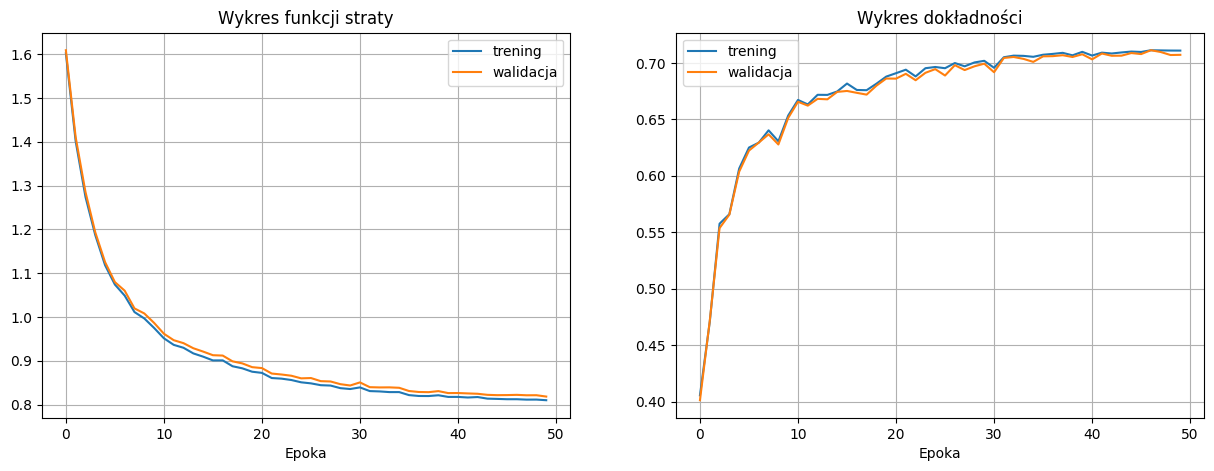

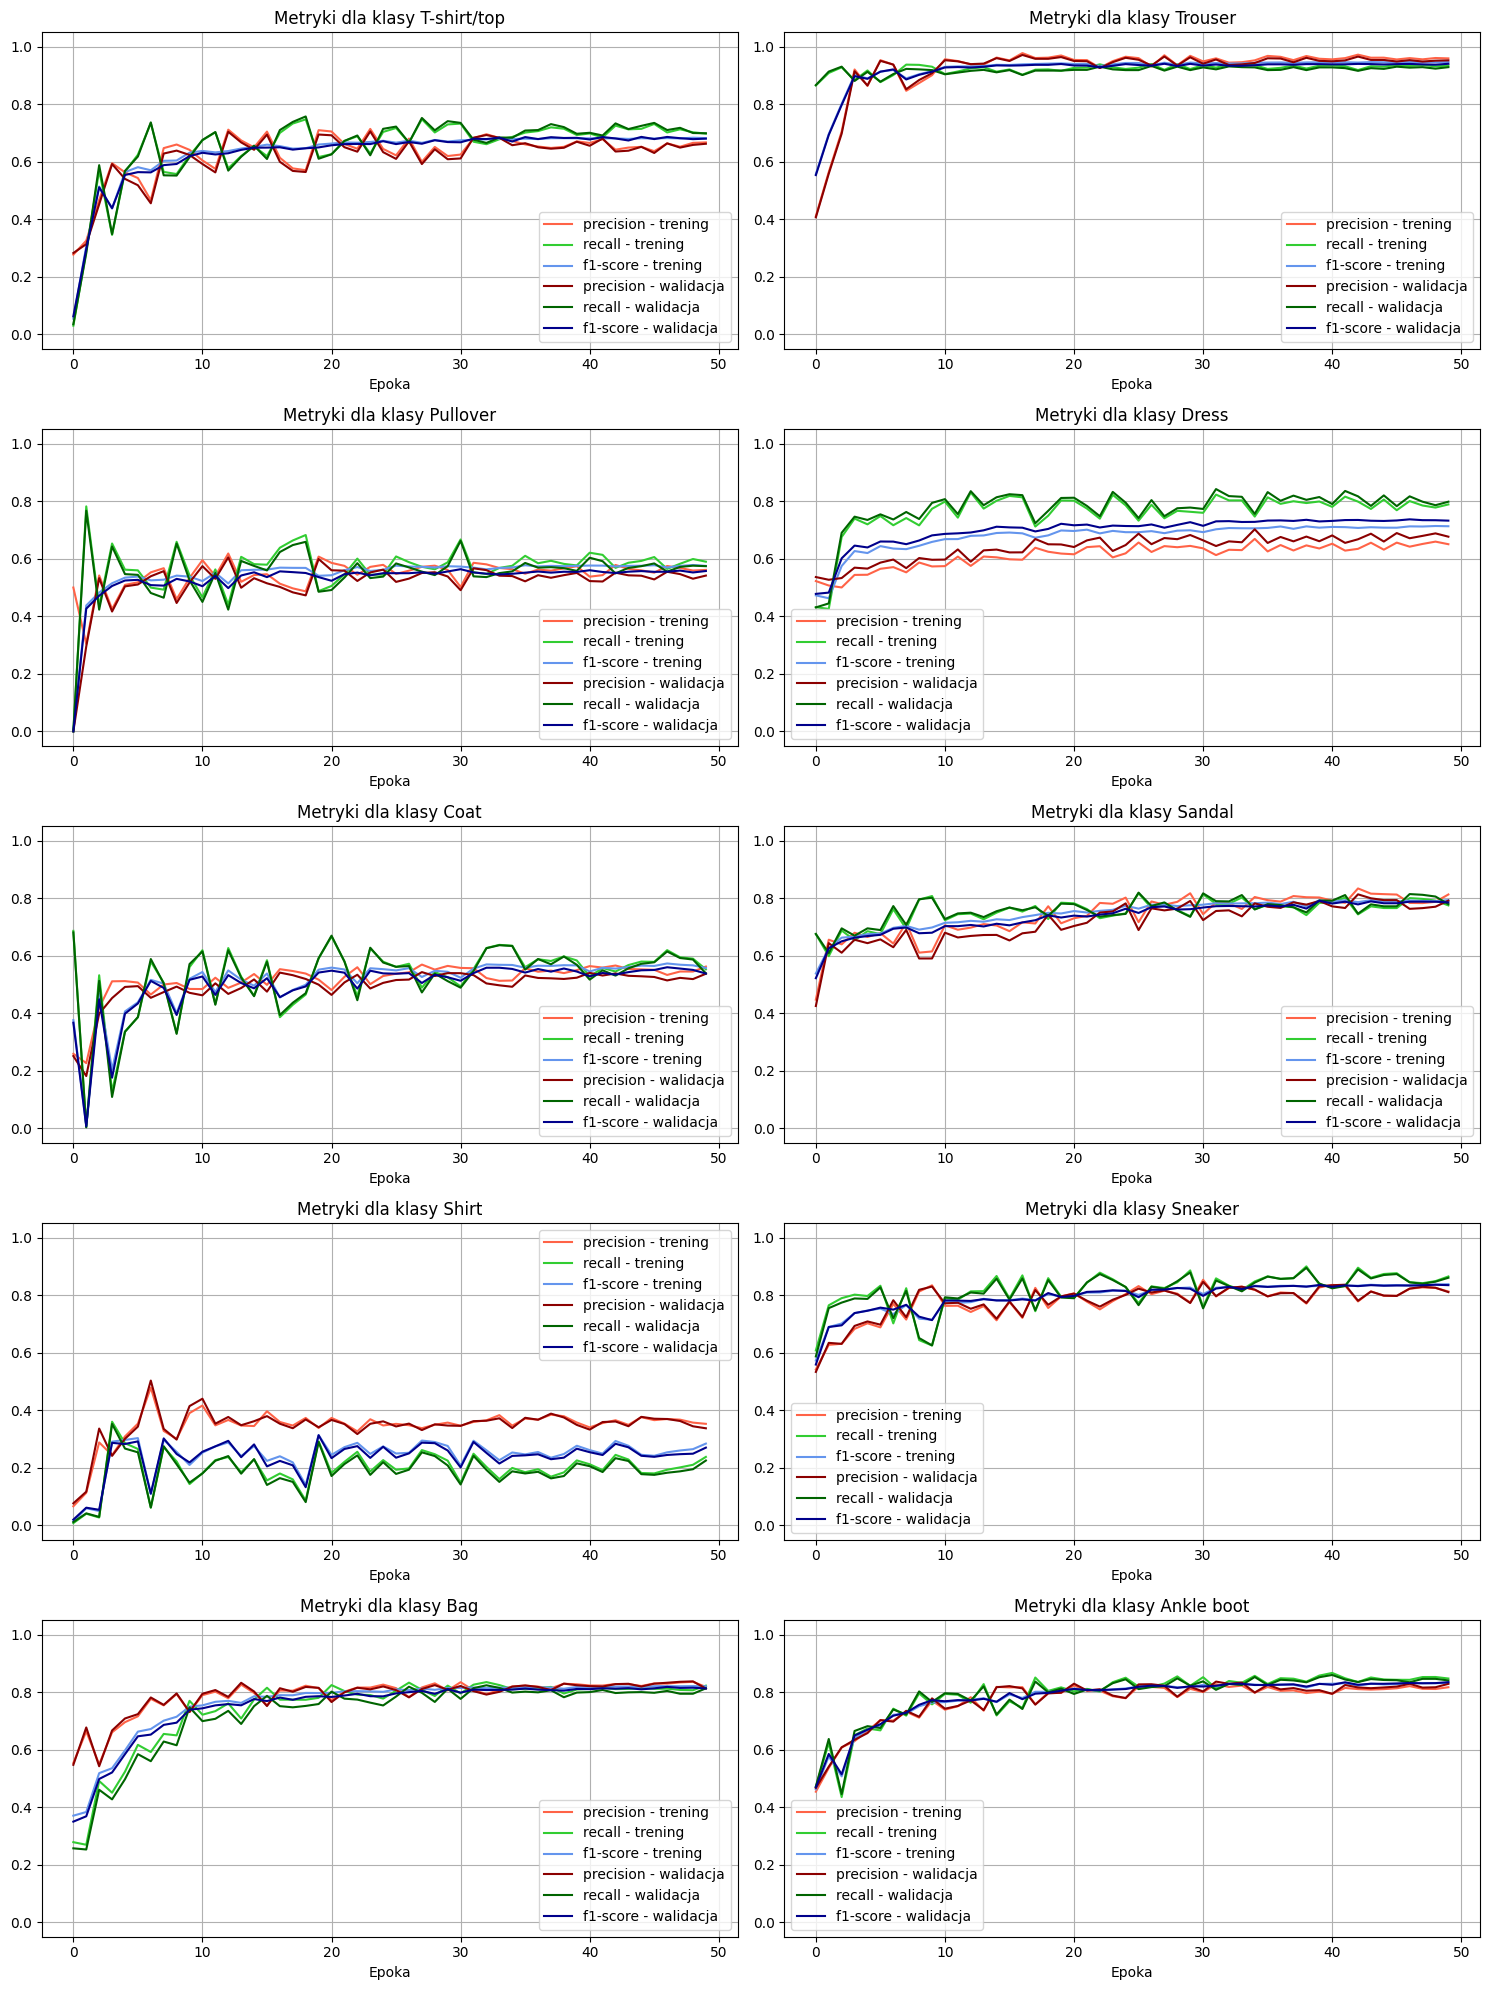

In [ ]:
# +global pooling
cnn = CNNmodel(pooling='max', global_pooling=True)

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num, eta_min=0.0001)

trainer = m.TrainingClass(cnn, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler, patience=15)
tr_losses1, val_losses1, tr_metrics1, val_metrics1, tr_accuracies1, val_accuracies1 = trainer.training_loop(epochs_num, "cnn-global-pool", trainloader, validationloader, testloader)

m.create_loss_and_accuracy_plot(tr_losses1, val_losses1, tr_accuracies1, val_accuracies1)
m.create_metrics_plot(tr_metrics1, val_metrics1)

In [ ]:
summary(cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNmodel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 4, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 8, 14, 14]            296
│    └─ReLU: 2-5                         [1, 8, 14, 14]            --
│    └─MaxPool2d: 2-6                    [1, 8, 7, 7]              --
│    └─AdaptiveAvgPool2d: 2-7            [1, 8, 1, 1]              --
│    └─Flatten: 2-8                      [1, 8]                    --
│    └─Linear: 2-9                       [1, 10]                   90
Total params: 426
Trainable params: 426
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.09
Input size (MB): 0.00
Forward/backward pass size (

# Eksperymenty z batch norm i dropout

Przeprowadzone niżej eksperymenty pokazują, że zastosowanie zarówno batch norm jak i dropout nie pogorszyło generalizacji, jednak spośród obu tych technik to batch norm znacznie poprawiło metryki modelu oraz zmniejszyło funkcję straty, dlatego w kolejnych eksperymentach pozostanę przy wersji z batch norm.

  2%|▏         | 1/50 [00:23<19:13, 23.54s/it]

LR: 0.0010
epoch: 1, train loss: 1.646, validation loss: 1.644


  4%|▍         | 2/50 [00:45<18:09, 22.71s/it]

LR: 0.0010


  6%|▌         | 3/50 [01:07<17:38, 22.52s/it]

LR: 0.0010
epoch: 3, train loss: 1.127, validation loss: 1.118


  8%|▊         | 4/50 [01:30<17:24, 22.71s/it]

LR: 0.0010


 10%|█         | 5/50 [01:52<16:44, 22.33s/it]

LR: 0.0010
epoch: 5, train loss: 0.990, validation loss: 0.978


 12%|█▏        | 6/50 [02:15<16:37, 22.67s/it]

LR: 0.0010


 14%|█▍        | 7/50 [02:42<17:12, 24.01s/it]

LR: 0.0010
epoch: 7, train loss: 0.912, validation loss: 0.898


 16%|█▌        | 8/50 [03:04<16:20, 23.35s/it]

LR: 0.0009


 18%|█▊        | 9/50 [03:27<15:56, 23.33s/it]

LR: 0.0009
epoch: 9, train loss: 0.864, validation loss: 0.851


 20%|██        | 10/50 [03:51<15:32, 23.31s/it]

LR: 0.0009


 22%|██▏       | 11/50 [04:12<14:47, 22.77s/it]

LR: 0.0009
epoch: 11, train loss: 0.839, validation loss: 0.828


 24%|██▍       | 12/50 [04:35<14:25, 22.76s/it]

LR: 0.0009


 26%|██▌       | 13/50 [04:57<13:50, 22.45s/it]

LR: 0.0009
epoch: 13, train loss: 0.810, validation loss: 0.801


 28%|██▊       | 14/50 [05:19<13:28, 22.47s/it]

LR: 0.0008


 30%|███       | 15/50 [05:42<13:11, 22.61s/it]

LR: 0.0008
epoch: 15, train loss: 0.776, validation loss: 0.767


 32%|███▏      | 16/50 [06:04<12:39, 22.35s/it]

LR: 0.0008


 34%|███▍      | 17/50 [06:27<12:26, 22.63s/it]

LR: 0.0008
epoch: 17, train loss: 0.752, validation loss: 0.740


 36%|███▌      | 18/50 [06:50<12:08, 22.78s/it]

LR: 0.0007


 38%|███▊      | 19/50 [07:13<11:42, 22.65s/it]

LR: 0.0007
epoch: 19, train loss: 0.727, validation loss: 0.718


 40%|████      | 20/50 [07:36<11:24, 22.83s/it]

LR: 0.0007


 42%|████▏     | 21/50 [07:58<10:51, 22.47s/it]

LR: 0.0007
epoch: 21, train loss: 0.713, validation loss: 0.704


 44%|████▍     | 22/50 [08:20<10:32, 22.60s/it]

LR: 0.0006


 46%|████▌     | 23/50 [08:43<10:10, 22.61s/it]

LR: 0.0006
epoch: 23, train loss: 0.700, validation loss: 0.691


 48%|████▊     | 24/50 [09:04<09:38, 22.24s/it]

LR: 0.0006


 50%|█████     | 25/50 [09:27<09:19, 22.38s/it]

LR: 0.0005
epoch: 25, train loss: 0.721, validation loss: 0.716


 52%|█████▏    | 26/50 [09:48<08:49, 22.05s/it]

LR: 0.0005


 54%|█████▍    | 27/50 [10:11<08:31, 22.22s/it]

LR: 0.0005
epoch: 27, train loss: 0.682, validation loss: 0.674


 56%|█████▌    | 28/50 [10:33<08:08, 22.18s/it]

LR: 0.0005


 58%|█████▊    | 29/50 [10:55<07:43, 22.09s/it]

LR: 0.0004
epoch: 29, train loss: 0.678, validation loss: 0.673


 60%|██████    | 30/50 [11:18<07:26, 22.33s/it]

LR: 0.0004


 62%|██████▏   | 31/50 [11:39<06:57, 21.98s/it]

LR: 0.0004
epoch: 31, train loss: 0.674, validation loss: 0.668


 64%|██████▍   | 32/50 [12:02<06:41, 22.29s/it]

LR: 0.0004


 66%|██████▌   | 33/50 [12:24<06:18, 22.25s/it]

LR: 0.0003
epoch: 33, train loss: 0.668, validation loss: 0.663


 68%|██████▊   | 34/50 [12:47<05:56, 22.28s/it]

LR: 0.0003


 70%|███████   | 35/50 [13:10<05:37, 22.48s/it]

LR: 0.0003
epoch: 35, train loss: 0.664, validation loss: 0.659


 72%|███████▏  | 36/50 [13:31<05:10, 22.16s/it]

LR: 0.0003


 74%|███████▍  | 37/50 [13:54<04:50, 22.34s/it]

LR: 0.0002
epoch: 37, train loss: 0.661, validation loss: 0.657


 76%|███████▌  | 38/50 [14:16<04:26, 22.22s/it]

LR: 0.0002


 78%|███████▊  | 39/50 [14:38<04:05, 22.33s/it]

LR: 0.0002
epoch: 39, train loss: 0.654, validation loss: 0.649


 80%|████████  | 40/50 [15:02<03:46, 22.67s/it]

LR: 0.0002


 82%|████████▏ | 41/50 [15:24<03:22, 22.51s/it]

LR: 0.0002
epoch: 41, train loss: 0.654, validation loss: 0.651


 84%|████████▍ | 42/50 [15:47<03:01, 22.73s/it]

LR: 0.0002


 86%|████████▌ | 43/50 [16:10<02:40, 22.92s/it]

LR: 0.0001
epoch: 43, train loss: 0.649, validation loss: 0.645


 88%|████████▊ | 44/50 [16:32<02:15, 22.59s/it]

LR: 0.0001


 90%|█████████ | 45/50 [16:56<01:53, 22.80s/it]

LR: 0.0001
epoch: 45, train loss: 0.650, validation loss: 0.645


 92%|█████████▏| 46/50 [17:18<01:31, 22.81s/it]

LR: 0.0001


 94%|█████████▍| 47/50 [17:41<01:07, 22.59s/it]

LR: 0.0001
epoch: 47, train loss: 0.644, validation loss: 0.639


 96%|█████████▌| 48/50 [18:04<00:45, 22.76s/it]

LR: 0.0001


 98%|█████████▊| 49/50 [18:25<00:22, 22.41s/it]

LR: 0.0001
epoch: 49, train loss: 0.644, validation loss: 0.640


100%|██████████| 50/50 [18:48<00:00, 22.58s/it]

LR: 0.0001


test loss: 0.664


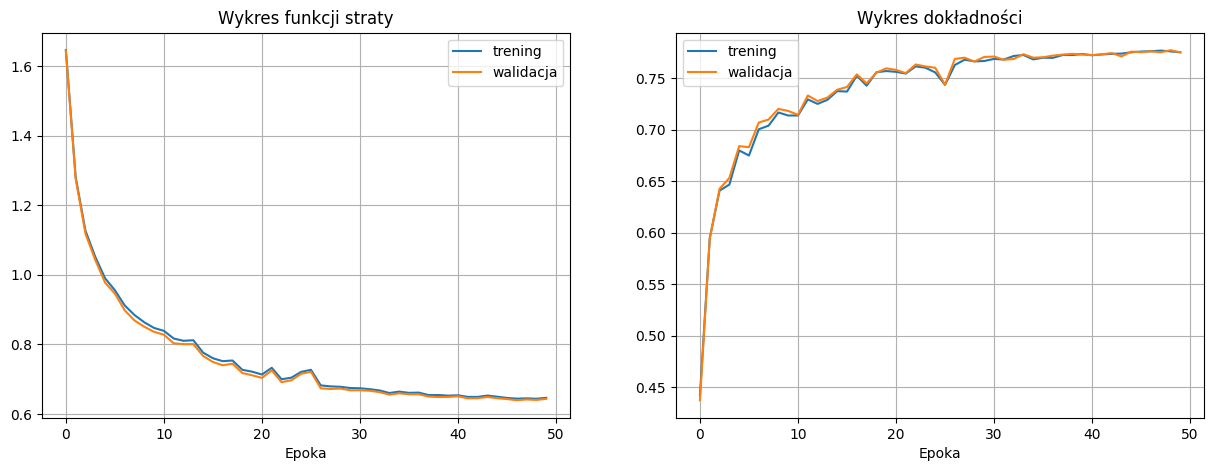

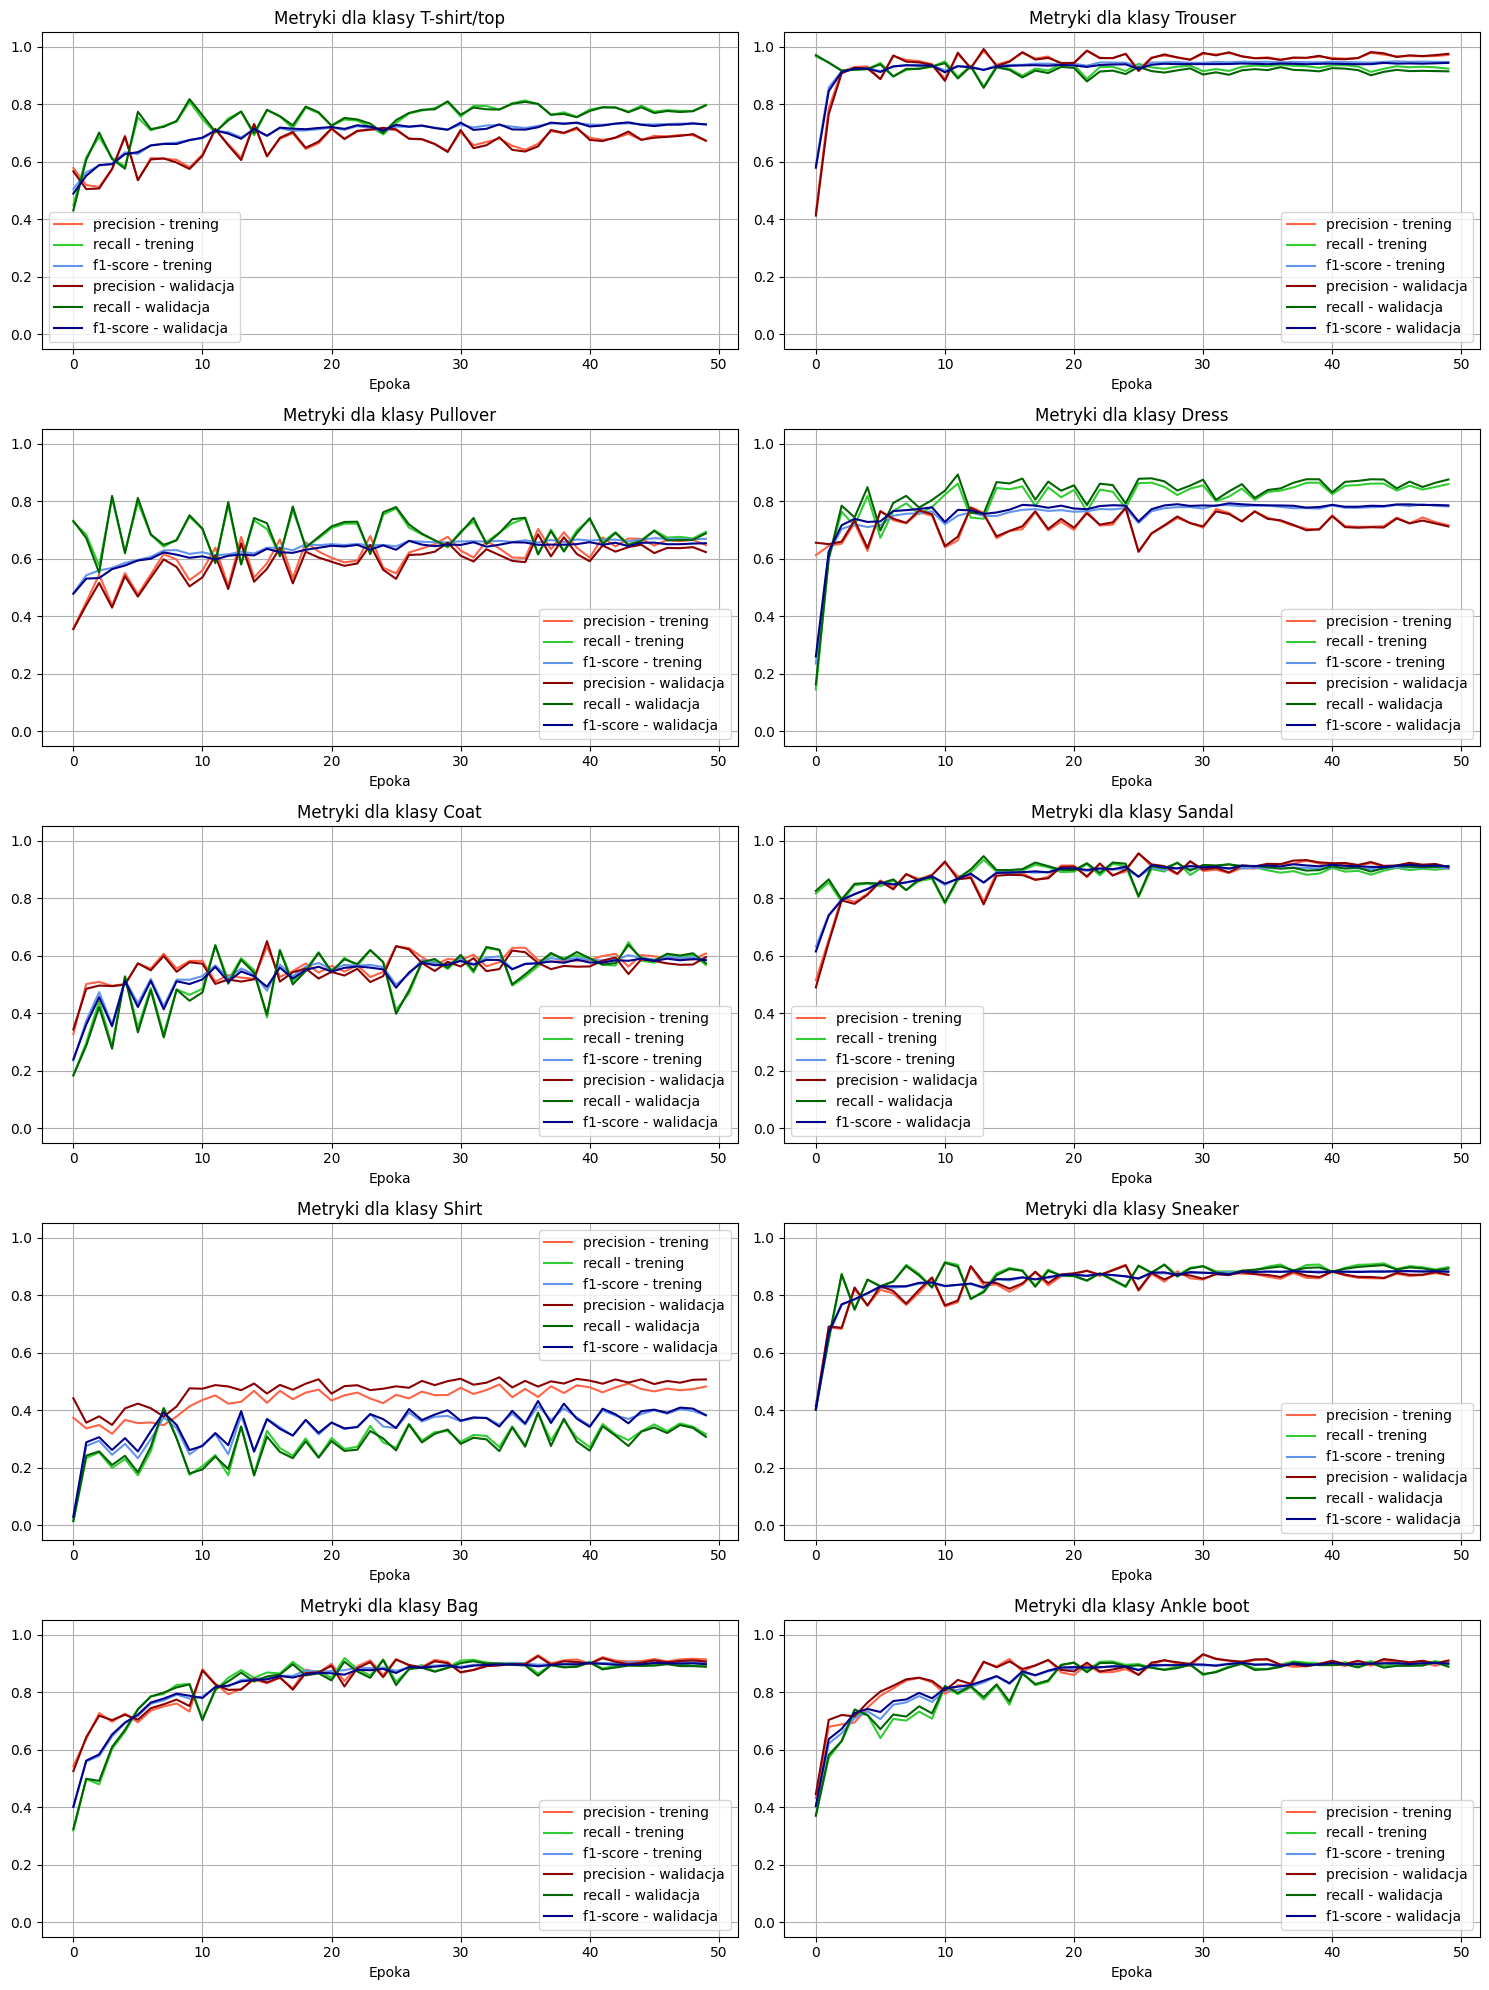

In [ ]:
# batch_norm
cnn = CNNmodel(pooling='max', global_pooling=True, batch_norm=True)

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num, eta_min=0.0001)

trainer = m.TrainingClass(cnn, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler, patience=15)
tr_losses1, val_losses1, tr_metrics1, val_metrics1, tr_accuracies1, val_accuracies1 = trainer.training_loop(epochs_num, "cnn-batch-norm", trainloader, validationloader, testloader)

m.create_loss_and_accuracy_plot(tr_losses1, val_losses1, tr_accuracies1, val_accuracies1)
m.create_metrics_plot(tr_metrics1, val_metrics1)

In [ ]:
summary(cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNmodel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─BatchNorm2d: 2-2                  [1, 4, 28, 28]            8
│    └─ReLU: 2-3                         [1, 4, 28, 28]            --
│    └─MaxPool2d: 2-4                    [1, 4, 14, 14]            --
│    └─Conv2d: 2-5                       [1, 8, 14, 14]            296
│    └─BatchNorm2d: 2-6                  [1, 8, 14, 14]            16
│    └─ReLU: 2-7                         [1, 8, 14, 14]            --
│    └─MaxPool2d: 2-8                    [1, 8, 7, 7]              --
│    └─AdaptiveAvgPool2d: 2-9            [1, 8, 1, 1]              --
│    └─Flatten: 2-10                     [1, 8]                    --
│    └─Linear: 2-11                      [1, 10]                   90
Total params: 4

  2%|▏         | 1/50 [00:22<18:12, 22.30s/it]

LR: 0.0010
epoch: 1, train loss: 1.907, validation loss: 1.906


  4%|▍         | 2/50 [00:44<17:54, 22.38s/it]

LR: 0.0010


  6%|▌         | 3/50 [01:07<17:45, 22.67s/it]

LR: 0.0010
epoch: 3, train loss: 1.498, validation loss: 1.496


  8%|▊         | 4/50 [01:29<17:03, 22.25s/it]

LR: 0.0010


 10%|█         | 5/50 [01:52<16:53, 22.52s/it]

LR: 0.0010
epoch: 5, train loss: 1.379, validation loss: 1.376


 12%|█▏        | 6/50 [02:15<16:40, 22.74s/it]

LR: 0.0010


 14%|█▍        | 7/50 [02:37<16:02, 22.38s/it]

LR: 0.0010
epoch: 7, train loss: 1.311, validation loss: 1.307


 16%|█▌        | 8/50 [03:00<15:47, 22.57s/it]

LR: 0.0009


 18%|█▊        | 9/50 [03:21<15:07, 22.14s/it]

LR: 0.0009
epoch: 9, train loss: 1.264, validation loss: 1.260


 20%|██        | 10/50 [03:44<14:54, 22.35s/it]

LR: 0.0009


 22%|██▏       | 11/50 [04:06<14:32, 22.36s/it]

LR: 0.0009
epoch: 11, train loss: 1.238, validation loss: 1.234


 24%|██▍       | 12/50 [04:28<14:01, 22.14s/it]

LR: 0.0009


 26%|██▌       | 13/50 [04:50<13:46, 22.35s/it]

LR: 0.0009
epoch: 13, train loss: 1.199, validation loss: 1.196


 28%|██▊       | 14/50 [05:12<13:14, 22.06s/it]

LR: 0.0008


 30%|███       | 15/50 [05:35<13:03, 22.40s/it]

LR: 0.0008
epoch: 15, train loss: 1.160, validation loss: 1.156


 32%|███▏      | 16/50 [05:57<12:40, 22.37s/it]

LR: 0.0008


 34%|███▍      | 17/50 [06:19<12:15, 22.29s/it]

LR: 0.0008
epoch: 17, train loss: 1.144, validation loss: 1.140


 36%|███▌      | 18/50 [06:49<13:02, 24.45s/it]

LR: 0.0007


 38%|███▊      | 19/50 [07:14<12:43, 24.63s/it]

LR: 0.0007
epoch: 19, train loss: 1.116, validation loss: 1.112


 40%|████      | 20/50 [07:40<12:33, 25.12s/it]

LR: 0.0007


 42%|████▏     | 21/50 [08:06<12:10, 25.20s/it]

LR: 0.0007
epoch: 21, train loss: 1.104, validation loss: 1.100


 44%|████▍     | 22/50 [08:27<11:14, 24.10s/it]

LR: 0.0006


 46%|████▌     | 23/50 [08:50<10:40, 23.74s/it]

LR: 0.0006
epoch: 23, train loss: 1.103, validation loss: 1.100


 48%|████▊     | 24/50 [09:13<10:12, 23.55s/it]

LR: 0.0006


 50%|█████     | 25/50 [09:35<09:39, 23.17s/it]

LR: 0.0005
epoch: 25, train loss: 1.098, validation loss: 1.094


 52%|█████▏    | 26/50 [09:58<09:12, 23.04s/it]

LR: 0.0005


 54%|█████▍    | 27/50 [10:20<08:39, 22.58s/it]

LR: 0.0005
epoch: 27, train loss: 1.080, validation loss: 1.076


 56%|█████▌    | 28/50 [10:43<08:18, 22.67s/it]

LR: 0.0005


 58%|█████▊    | 29/50 [11:04<07:48, 22.32s/it]

LR: 0.0004
epoch: 29, train loss: 1.080, validation loss: 1.076


 60%|██████    | 30/50 [11:26<07:25, 22.27s/it]

LR: 0.0004


 62%|██████▏   | 31/50 [11:49<07:05, 22.40s/it]

LR: 0.0004
epoch: 31, train loss: 1.072, validation loss: 1.068


 64%|██████▍   | 32/50 [12:10<06:37, 22.06s/it]

LR: 0.0004


 66%|██████▌   | 33/50 [12:33<06:19, 22.31s/it]

LR: 0.0003
epoch: 33, train loss: 1.072, validation loss: 1.068


 68%|██████▊   | 34/50 [12:54<05:51, 21.97s/it]

LR: 0.0003


 70%|███████   | 35/50 [13:17<05:33, 22.20s/it]

LR: 0.0003
epoch: 35, train loss: 1.067, validation loss: 1.063


 72%|███████▏  | 36/50 [13:39<05:10, 22.15s/it]

LR: 0.0003


 74%|███████▍  | 37/50 [14:01<04:47, 22.15s/it]

LR: 0.0002
epoch: 37, train loss: 1.060, validation loss: 1.056


 76%|███████▌  | 38/50 [14:24<04:28, 22.37s/it]

LR: 0.0002


 78%|███████▊  | 39/50 [14:45<04:02, 22.06s/it]

LR: 0.0002
epoch: 39, train loss: 1.058, validation loss: 1.054


 80%|████████  | 40/50 [15:08<03:42, 22.23s/it]

LR: 0.0002


 82%|████████▏ | 41/50 [15:30<03:19, 22.22s/it]

LR: 0.0002
epoch: 41, train loss: 1.062, validation loss: 1.058


 84%|████████▍ | 42/50 [15:52<02:57, 22.23s/it]

LR: 0.0002


 86%|████████▌ | 43/50 [16:15<02:36, 22.42s/it]

LR: 0.0001
epoch: 43, train loss: 1.060, validation loss: 1.056


 88%|████████▊ | 44/50 [16:37<02:12, 22.11s/it]

LR: 0.0001


 90%|█████████ | 45/50 [17:00<01:51, 22.33s/it]

LR: 0.0001
epoch: 45, train loss: 1.057, validation loss: 1.053


 92%|█████████▏| 46/50 [17:22<01:28, 22.23s/it]

LR: 0.0001


 94%|█████████▍| 47/50 [17:44<01:06, 22.28s/it]

LR: 0.0001
epoch: 47, train loss: 1.055, validation loss: 1.051


 96%|█████████▌| 48/50 [18:07<00:44, 22.48s/it]

LR: 0.0001


 98%|█████████▊| 49/50 [18:28<00:22, 22.15s/it]

LR: 0.0001
epoch: 49, train loss: 1.058, validation loss: 1.054


100%|██████████| 50/50 [18:51<00:00, 22.63s/it]

LR: 0.0001


test loss: 1.064


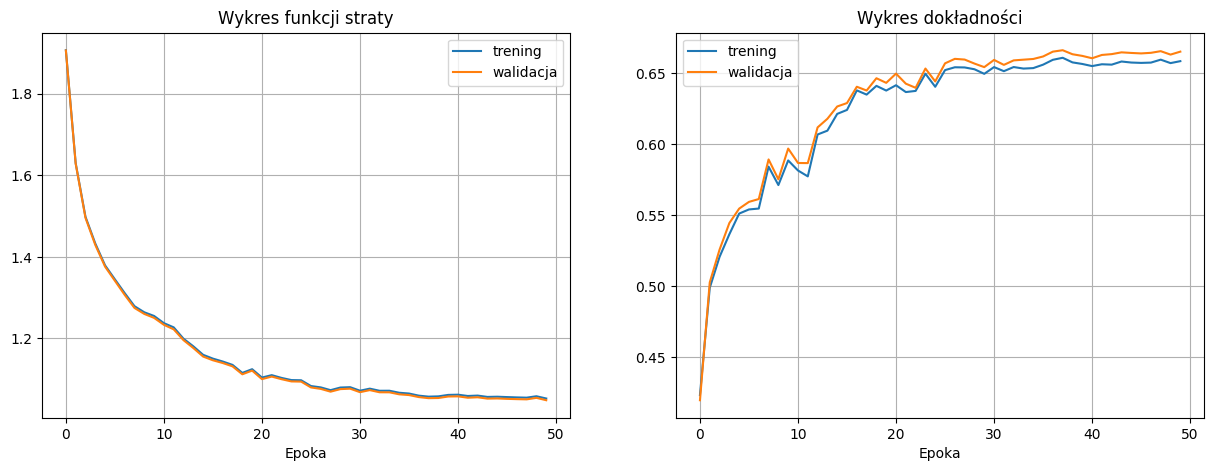

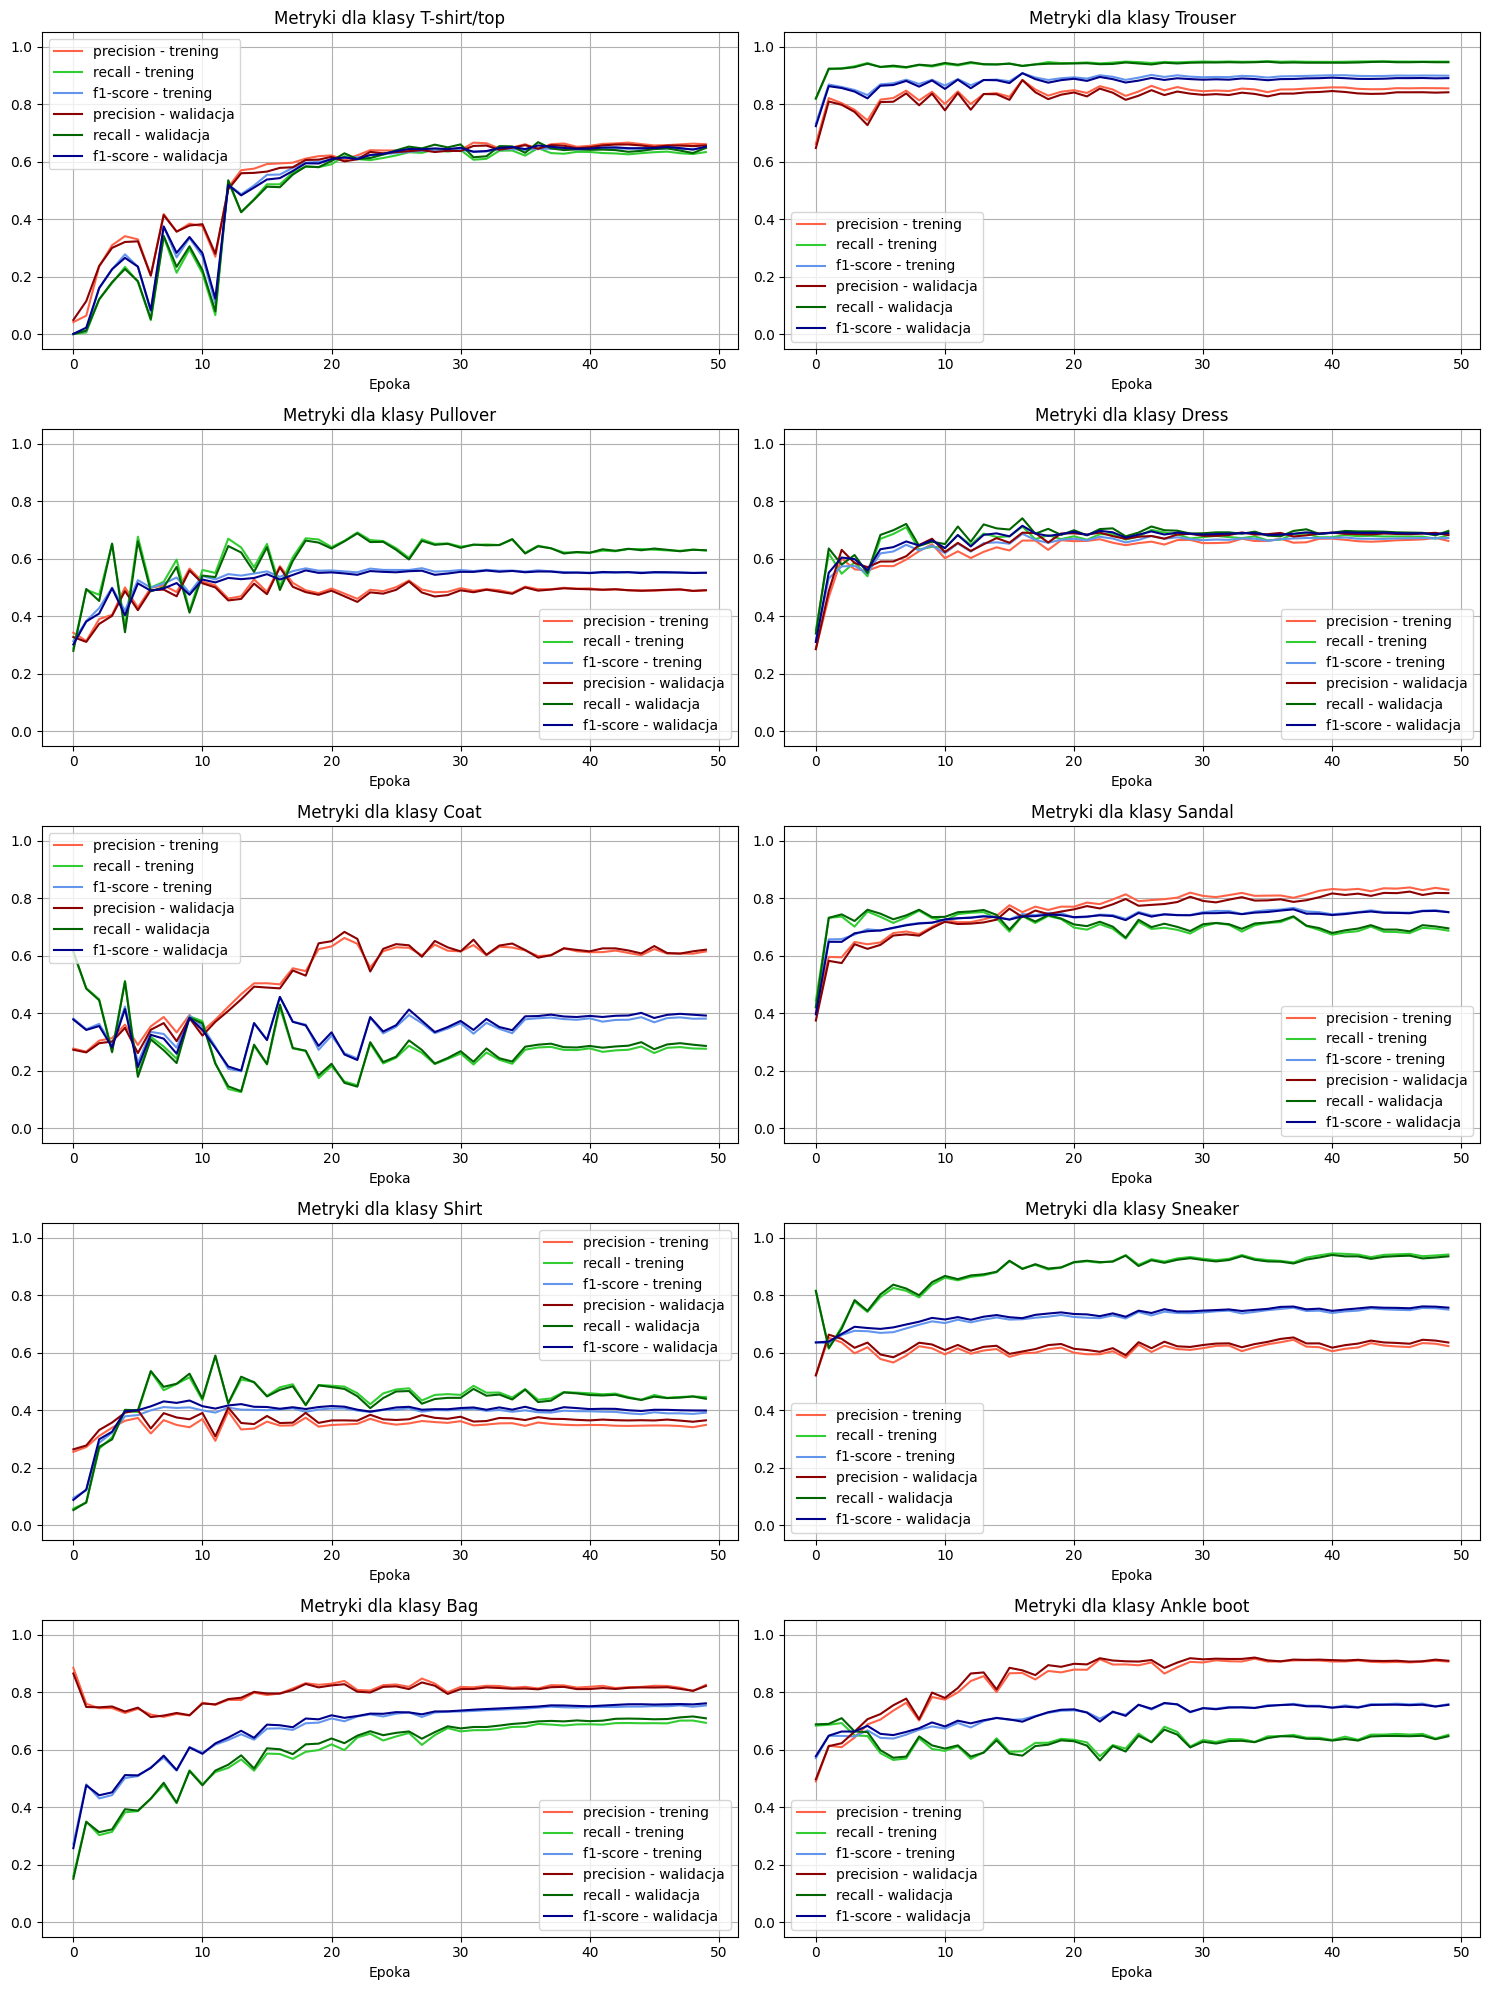

In [ ]:
# dropout
cnn = CNNmodel(pooling='max', global_pooling=True, dropout=0.2)

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num, eta_min=0.0001)

trainer = m.TrainingClass(cnn, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler, patience=15)
tr_losses1, val_losses1, tr_metrics1, val_metrics1, tr_accuracies1, val_accuracies1 = trainer.training_loop(epochs_num, "cnn-dropout", trainloader, validationloader, testloader)

m.create_loss_and_accuracy_plot(tr_losses1, val_losses1, tr_accuracies1, val_accuracies1)
m.create_metrics_plot(tr_metrics1, val_metrics1)

In [ ]:
summary(cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNmodel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 4, 14, 14]            --
│    └─Dropout2d: 2-4                    [1, 4, 14, 14]            --
│    └─Conv2d: 2-5                       [1, 8, 14, 14]            296
│    └─ReLU: 2-6                         [1, 8, 14, 14]            --
│    └─MaxPool2d: 2-7                    [1, 8, 7, 7]              --
│    └─Dropout2d: 2-8                    [1, 8, 7, 7]              --
│    └─AdaptiveAvgPool2d: 2-9            [1, 8, 1, 1]              --
│    └─Flatten: 2-10                     [1, 8]                    --
│    └─Linear: 2-11                      [1, 10]                   90
Total params: 

# Eksperyment z liczbą warstw i filtrów

Zastosowanie w tym eksperymencie bardziej złożonej sieci z większą liczbą warstw poskutkowało znaczącą poprawą metryk oraz funkcji straty, kosztem większego rozwarstwienia pomiędzy wynikami zbioru treningowego a walidacyjnego. Wyniki w tym eksperymencie są porównywalne z modelem bazowym z zadania 3, aczkolwiek w tym eksperymencie model zajmuje około 3 razy mniej pamięci oraz posiada około 10 razy mniej parametrów.

  0%|          | 0/50 [00:00<?, ?it/s]

LR: 0.0010


  2%|▏         | 1/50 [00:26<21:33, 26.40s/it]

epoch: 1, train loss: 0.443, validation loss: 0.456


  4%|▍         | 2/50 [00:47<18:37, 23.29s/it]

LR: 0.0010


  6%|▌         | 3/50 [01:08<17:22, 22.18s/it]

LR: 0.0010
epoch: 3, train loss: 0.327, validation loss: 0.359


  8%|▊         | 4/50 [01:30<16:54, 22.05s/it]

LR: 0.0010


 10%|█         | 5/50 [01:50<16:02, 21.38s/it]

LR: 0.0010
epoch: 5, train loss: 0.287, validation loss: 0.327


 12%|█▏        | 6/50 [02:12<15:44, 21.46s/it]

LR: 0.0010


 14%|█▍        | 7/50 [02:32<15:11, 21.20s/it]

LR: 0.0010
epoch: 7, train loss: 0.270, validation loss: 0.316


 16%|█▌        | 8/50 [02:54<14:58, 21.39s/it]

LR: 0.0009


 18%|█▊        | 9/50 [03:14<14:19, 20.97s/it]

LR: 0.0009
epoch: 9, train loss: 0.261, validation loss: 0.313


 20%|██        | 10/50 [03:36<14:05, 21.14s/it]

LR: 0.0009


 22%|██▏       | 11/50 [03:56<13:32, 20.82s/it]

LR: 0.0009
epoch: 11, train loss: 0.242, validation loss: 0.302


 24%|██▍       | 12/50 [04:17<13:18, 21.02s/it]

LR: 0.0009


 26%|██▌       | 13/50 [04:37<12:48, 20.77s/it]

LR: 0.0009
epoch: 13, train loss: 0.235, validation loss: 0.301


 28%|██▊       | 14/50 [05:00<12:47, 21.31s/it]

LR: 0.0008


 30%|███       | 15/50 [05:23<12:49, 21.99s/it]

LR: 0.0008
epoch: 15, train loss: 0.228, validation loss: 0.303


 32%|███▏      | 16/50 [05:44<12:09, 21.44s/it]

LR: 0.0008


 34%|███▍      | 17/50 [06:05<11:44, 21.35s/it]

LR: 0.0008
epoch: 17, train loss: 0.222, validation loss: 0.310


 36%|███▌      | 18/50 [06:25<11:14, 21.08s/it]

LR: 0.0007


 38%|███▊      | 19/50 [06:46<10:55, 21.14s/it]

LR: 0.0007
epoch: 19, train loss: 0.223, validation loss: 0.314


 40%|████      | 20/50 [07:06<10:23, 20.78s/it]

LR: 0.0007


 42%|████▏     | 21/50 [07:28<10:05, 20.87s/it]

LR: 0.0007
epoch: 21, train loss: 0.204, validation loss: 0.300


 44%|████▍     | 22/50 [07:47<09:34, 20.53s/it]

LR: 0.0006


 46%|████▌     | 23/50 [08:09<09:21, 20.79s/it]

LR: 0.0006
epoch: 23, train loss: 0.203, validation loss: 0.308


 48%|████▊     | 24/50 [08:29<08:55, 20.59s/it]

LR: 0.0006


 50%|█████     | 25/50 [08:50<08:39, 20.78s/it]

LR: 0.0005
epoch: 25, train loss: 0.200, validation loss: 0.306


 52%|█████▏    | 26/50 [09:10<08:11, 20.49s/it]

LR: 0.0005


 54%|█████▍    | 27/50 [09:31<07:56, 20.73s/it]

LR: 0.0005
epoch: 27, train loss: 0.193, validation loss: 0.305


 56%|█████▌    | 28/50 [09:51<07:29, 20.41s/it]

LR: 0.0005


 58%|█████▊    | 29/50 [10:12<07:12, 20.61s/it]

LR: 0.0004
epoch: 29, train loss: 0.185, validation loss: 0.300


 60%|██████    | 30/50 [10:32<06:47, 20.38s/it]

LR: 0.0004


 60%|██████    | 30/50 [10:53<07:15, 21.78s/it]

LR: 0.0004
Early stopping at epoch 31


test loss: 0.322


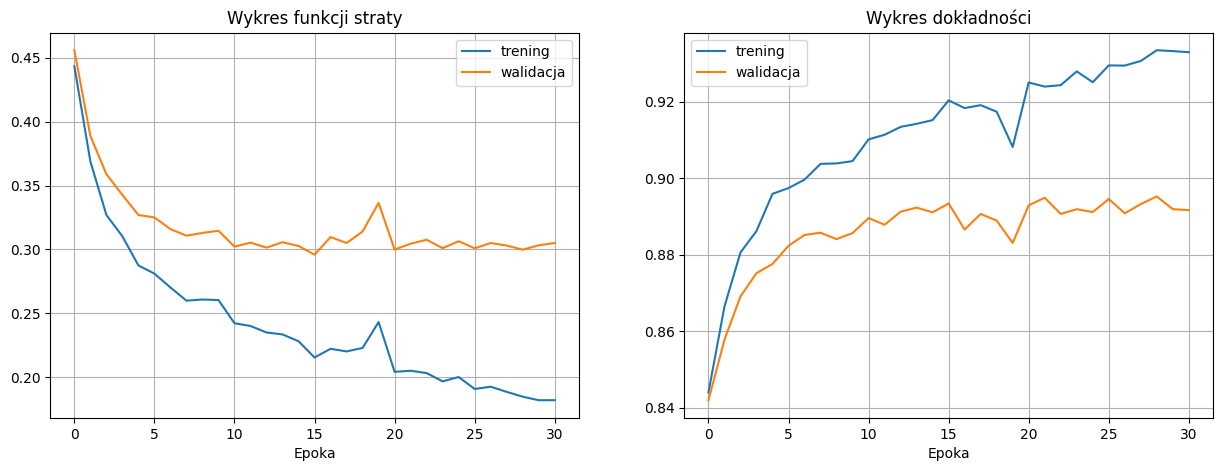

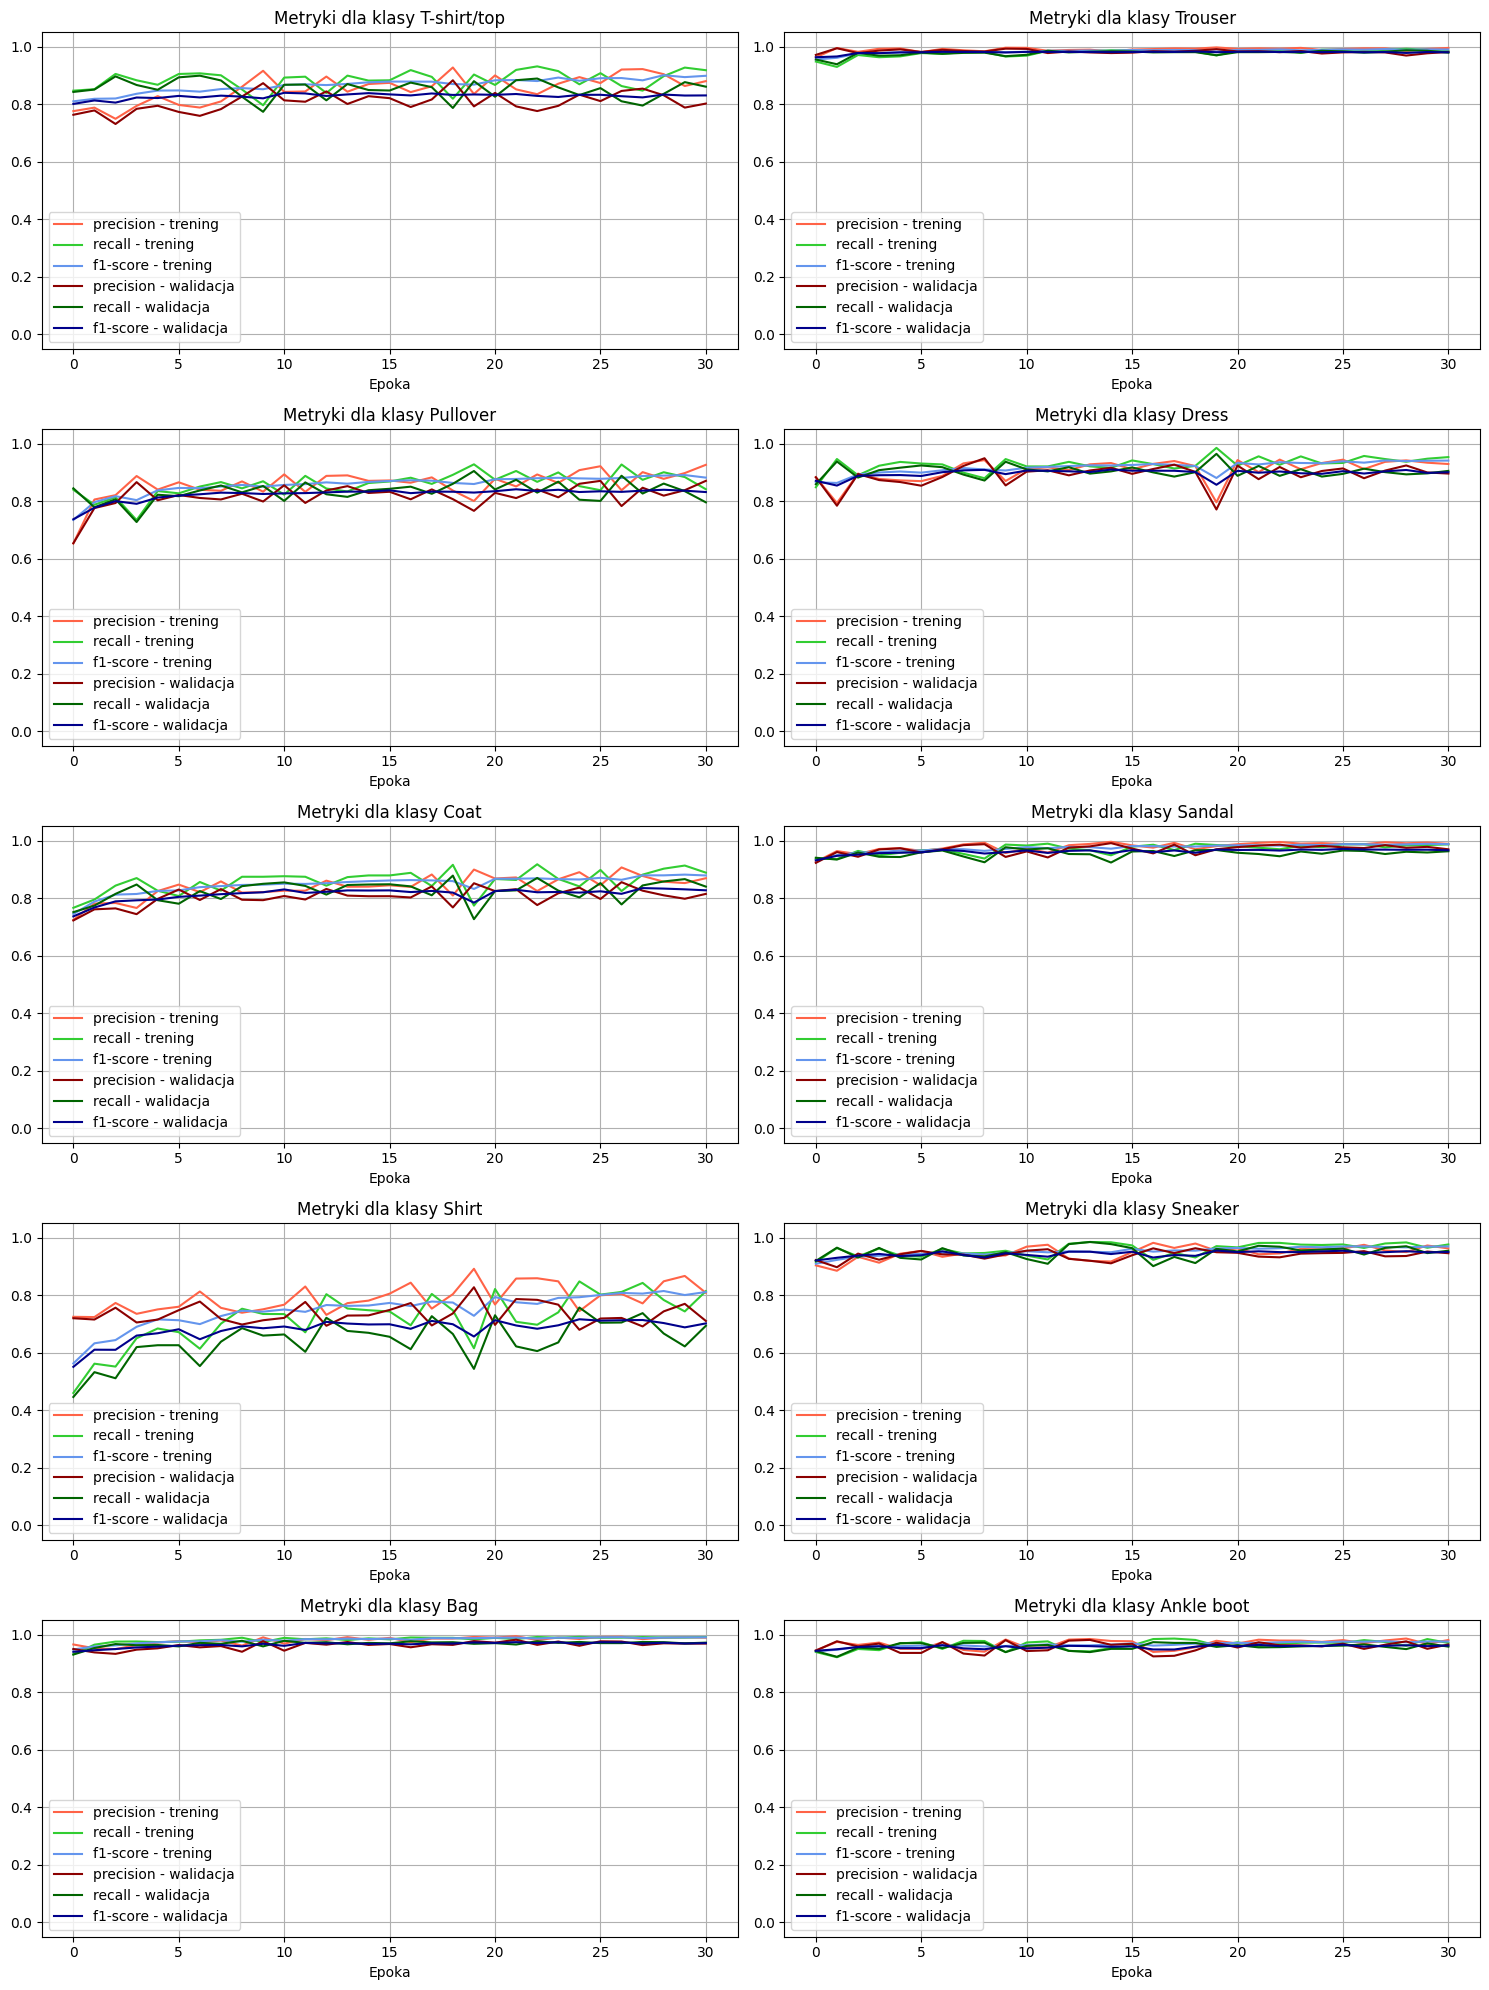

In [ ]:
# warstwy, filtry
cnn = CNNmodel(pooling='max', global_pooling=True, batch_norm=True, conv_layers_params=[
      (1, 4, 3, 1, 1, 1),
      (4, 8, 3, 1, 1, 1),
      (8, 16, 3, 1, 1, 1),
      (16, 32, 3, 1, 1, 1)
  ])

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num, eta_min=0.0001)

trainer = m.TrainingClass(cnn, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler, patience=15)
tr_losses1, val_losses1, tr_metrics1, val_metrics1, tr_accuracies1, val_accuracies1 = trainer.training_loop(epochs_num, "cnn-more-conv-layers", trainloader, validationloader, testloader)

m.create_loss_and_accuracy_plot(tr_losses1, val_losses1, tr_accuracies1, val_accuracies1)
m.create_metrics_plot(tr_metrics1, val_metrics1)

In [ ]:
summary(cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNmodel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─BatchNorm2d: 2-2                  [1, 4, 28, 28]            8
│    └─ReLU: 2-3                         [1, 4, 28, 28]            --
│    └─MaxPool2d: 2-4                    [1, 4, 14, 14]            --
│    └─Conv2d: 2-5                       [1, 8, 14, 14]            296
│    └─BatchNorm2d: 2-6                  [1, 8, 14, 14]            16
│    └─ReLU: 2-7                         [1, 8, 14, 14]            --
│    └─MaxPool2d: 2-8                    [1, 8, 7, 7]              --
│    └─Conv2d: 2-9                       [1, 16, 7, 7]             1,168
│    └─BatchNorm2d: 2-10                 [1, 16, 7, 7]             32
│    └─ReLU: 2-11                        [1, 16, 7, 7]             --
│    └─MaxPo

# Eksperyment ze zmodyfikowanymi parametrami warstw konwolucyjnych

W tym eksperymencie należało zmodyfikować 2 spośród parametrów `stride`, `padding` oraz `dilation`. Zważywszy na mały rozmiar obrazów MNIST (28x28) na wstępie wykluczyłem kombinację stride oraz dilation, ponieważ zwiększenie tych parametrów zbyt mocno skurczyłoby końcowy obraz. Ostatecznie wybrałem zwiększenie dilation oraz padding tak aby wyjściowy obraz nie był za mały. Padding ustawiłem na 2 tak, aby konwolucje na krańcach obrazu z ramką były wyśrodkowane na skrajnych pikselach obrazu wejściowego (bez ramki).
<br>
Poniższe wizualizacje pokazują, że zmiana tych parametrów wpłynęła w niewielkim stopniu na wyniki. Nieco pogorszyły się metryki oraz funkcja straty, jednak różnica pomiędzy zbiorem treningowym a walidacyjnym się trochę zmniejszyła.

  2%|▏         | 1/50 [00:21<17:35, 21.53s/it]

LR: 0.0010
epoch: 1, train loss: 0.497, validation loss: 0.498


  4%|▍         | 2/50 [00:48<19:39, 24.58s/it]

LR: 0.0010


  6%|▌         | 3/50 [01:12<19:13, 24.54s/it]

LR: 0.0010
epoch: 3, train loss: 0.387, validation loss: 0.406


  8%|▊         | 4/50 [01:39<19:25, 25.34s/it]

LR: 0.0010


 10%|█         | 5/50 [02:05<19:13, 25.64s/it]

LR: 0.0010
epoch: 5, train loss: 0.344, validation loss: 0.372


 12%|█▏        | 6/50 [02:27<17:54, 24.43s/it]

LR: 0.0010


 14%|█▍        | 7/50 [02:50<17:03, 23.81s/it]

LR: 0.0010
epoch: 7, train loss: 0.331, validation loss: 0.365


 16%|█▌        | 8/50 [03:10<16:00, 22.88s/it]

LR: 0.0009


 18%|█▊        | 9/50 [03:33<15:27, 22.61s/it]

LR: 0.0009
epoch: 9, train loss: 0.312, validation loss: 0.354


 20%|██        | 10/50 [03:55<14:57, 22.43s/it]

LR: 0.0009


 22%|██▏       | 11/50 [04:15<14:17, 21.98s/it]

LR: 0.0009
epoch: 11, train loss: 0.303, validation loss: 0.357


 24%|██▍       | 12/50 [04:37<13:53, 21.93s/it]

LR: 0.0009


 26%|██▌       | 13/50 [04:58<13:13, 21.45s/it]

LR: 0.0009
epoch: 13, train loss: 0.294, validation loss: 0.358


 28%|██▊       | 14/50 [05:19<12:54, 21.51s/it]

LR: 0.0008


 30%|███       | 15/50 [05:40<12:20, 21.17s/it]

LR: 0.0008
epoch: 15, train loss: 0.289, validation loss: 0.356


 32%|███▏      | 16/50 [06:01<12:05, 21.33s/it]

LR: 0.0008


 34%|███▍      | 17/50 [06:22<11:37, 21.14s/it]

LR: 0.0008
epoch: 17, train loss: 0.277, validation loss: 0.344


 36%|███▌      | 18/50 [06:44<11:21, 21.29s/it]

LR: 0.0007


 38%|███▊      | 19/50 [07:05<11:00, 21.31s/it]

LR: 0.0007
epoch: 19, train loss: 0.271, validation loss: 0.344


 40%|████      | 20/50 [07:27<10:41, 21.39s/it]

LR: 0.0007


 42%|████▏     | 21/50 [07:48<10:21, 21.43s/it]

LR: 0.0007
epoch: 21, train loss: 0.263, validation loss: 0.342


 44%|████▍     | 22/50 [08:09<09:58, 21.37s/it]

LR: 0.0006


 46%|████▌     | 23/50 [08:34<10:02, 22.33s/it]

LR: 0.0006
epoch: 23, train loss: 0.262, validation loss: 0.343


 48%|████▊     | 24/50 [08:55<09:33, 22.04s/it]

LR: 0.0006


 50%|█████     | 25/50 [09:18<09:12, 22.09s/it]

LR: 0.0005
epoch: 25, train loss: 0.256, validation loss: 0.339


 52%|█████▏    | 26/50 [09:39<08:47, 21.97s/it]

LR: 0.0005


 54%|█████▍    | 27/50 [10:00<08:19, 21.70s/it]

LR: 0.0005
epoch: 27, train loss: 0.251, validation loss: 0.339


 56%|█████▌    | 28/50 [10:22<07:58, 21.77s/it]

LR: 0.0005


 58%|█████▊    | 29/50 [10:43<07:30, 21.44s/it]

LR: 0.0004
epoch: 29, train loss: 0.252, validation loss: 0.348


 60%|██████    | 30/50 [11:05<07:13, 21.68s/it]

LR: 0.0004


 62%|██████▏   | 31/50 [11:26<06:49, 21.53s/it]

LR: 0.0004
epoch: 31, train loss: 0.245, validation loss: 0.340


 64%|██████▍   | 32/50 [11:49<06:33, 21.87s/it]

LR: 0.0004


 66%|██████▌   | 33/50 [12:11<06:11, 21.85s/it]

LR: 0.0003
epoch: 33, train loss: 0.244, validation loss: 0.344


 68%|██████▊   | 34/50 [12:33<05:50, 21.92s/it]

LR: 0.0003


 70%|███████   | 35/50 [12:55<05:31, 22.08s/it]

LR: 0.0003
epoch: 35, train loss: 0.239, validation loss: 0.342


 72%|███████▏  | 36/50 [13:17<05:05, 21.85s/it]

LR: 0.0003


 74%|███████▍  | 37/50 [13:39<04:46, 22.07s/it]

LR: 0.0002
epoch: 37, train loss: 0.236, validation loss: 0.344


 76%|███████▌  | 38/50 [14:01<04:23, 21.97s/it]

LR: 0.0002


 78%|███████▊  | 39/50 [14:23<04:00, 21.90s/it]

LR: 0.0002
epoch: 39, train loss: 0.235, validation loss: 0.346


 80%|████████  | 40/50 [14:45<03:40, 22.06s/it]

LR: 0.0002


 80%|████████  | 40/50 [15:06<03:46, 22.67s/it]

LR: 0.0002
Early stopping at epoch 41


test loss: 0.356


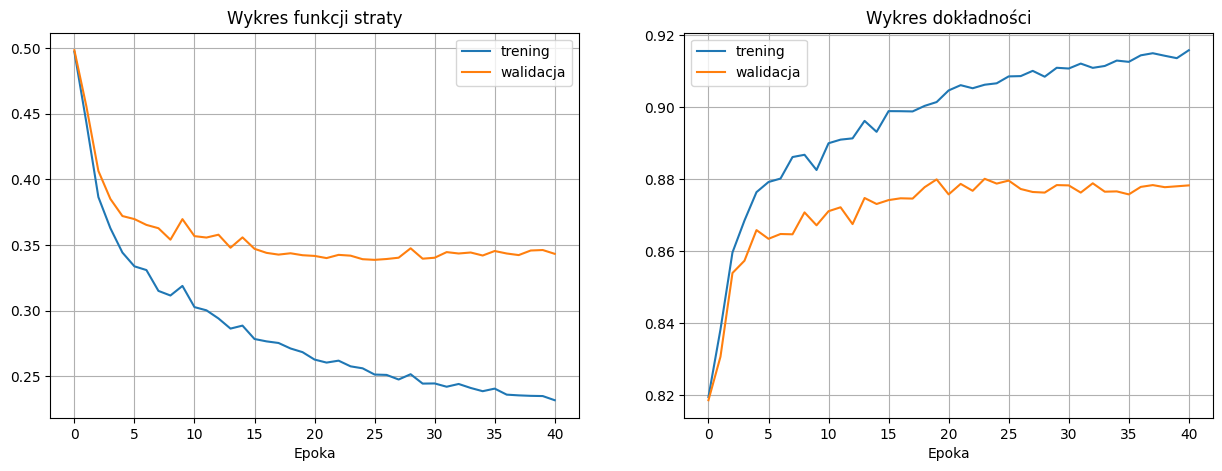

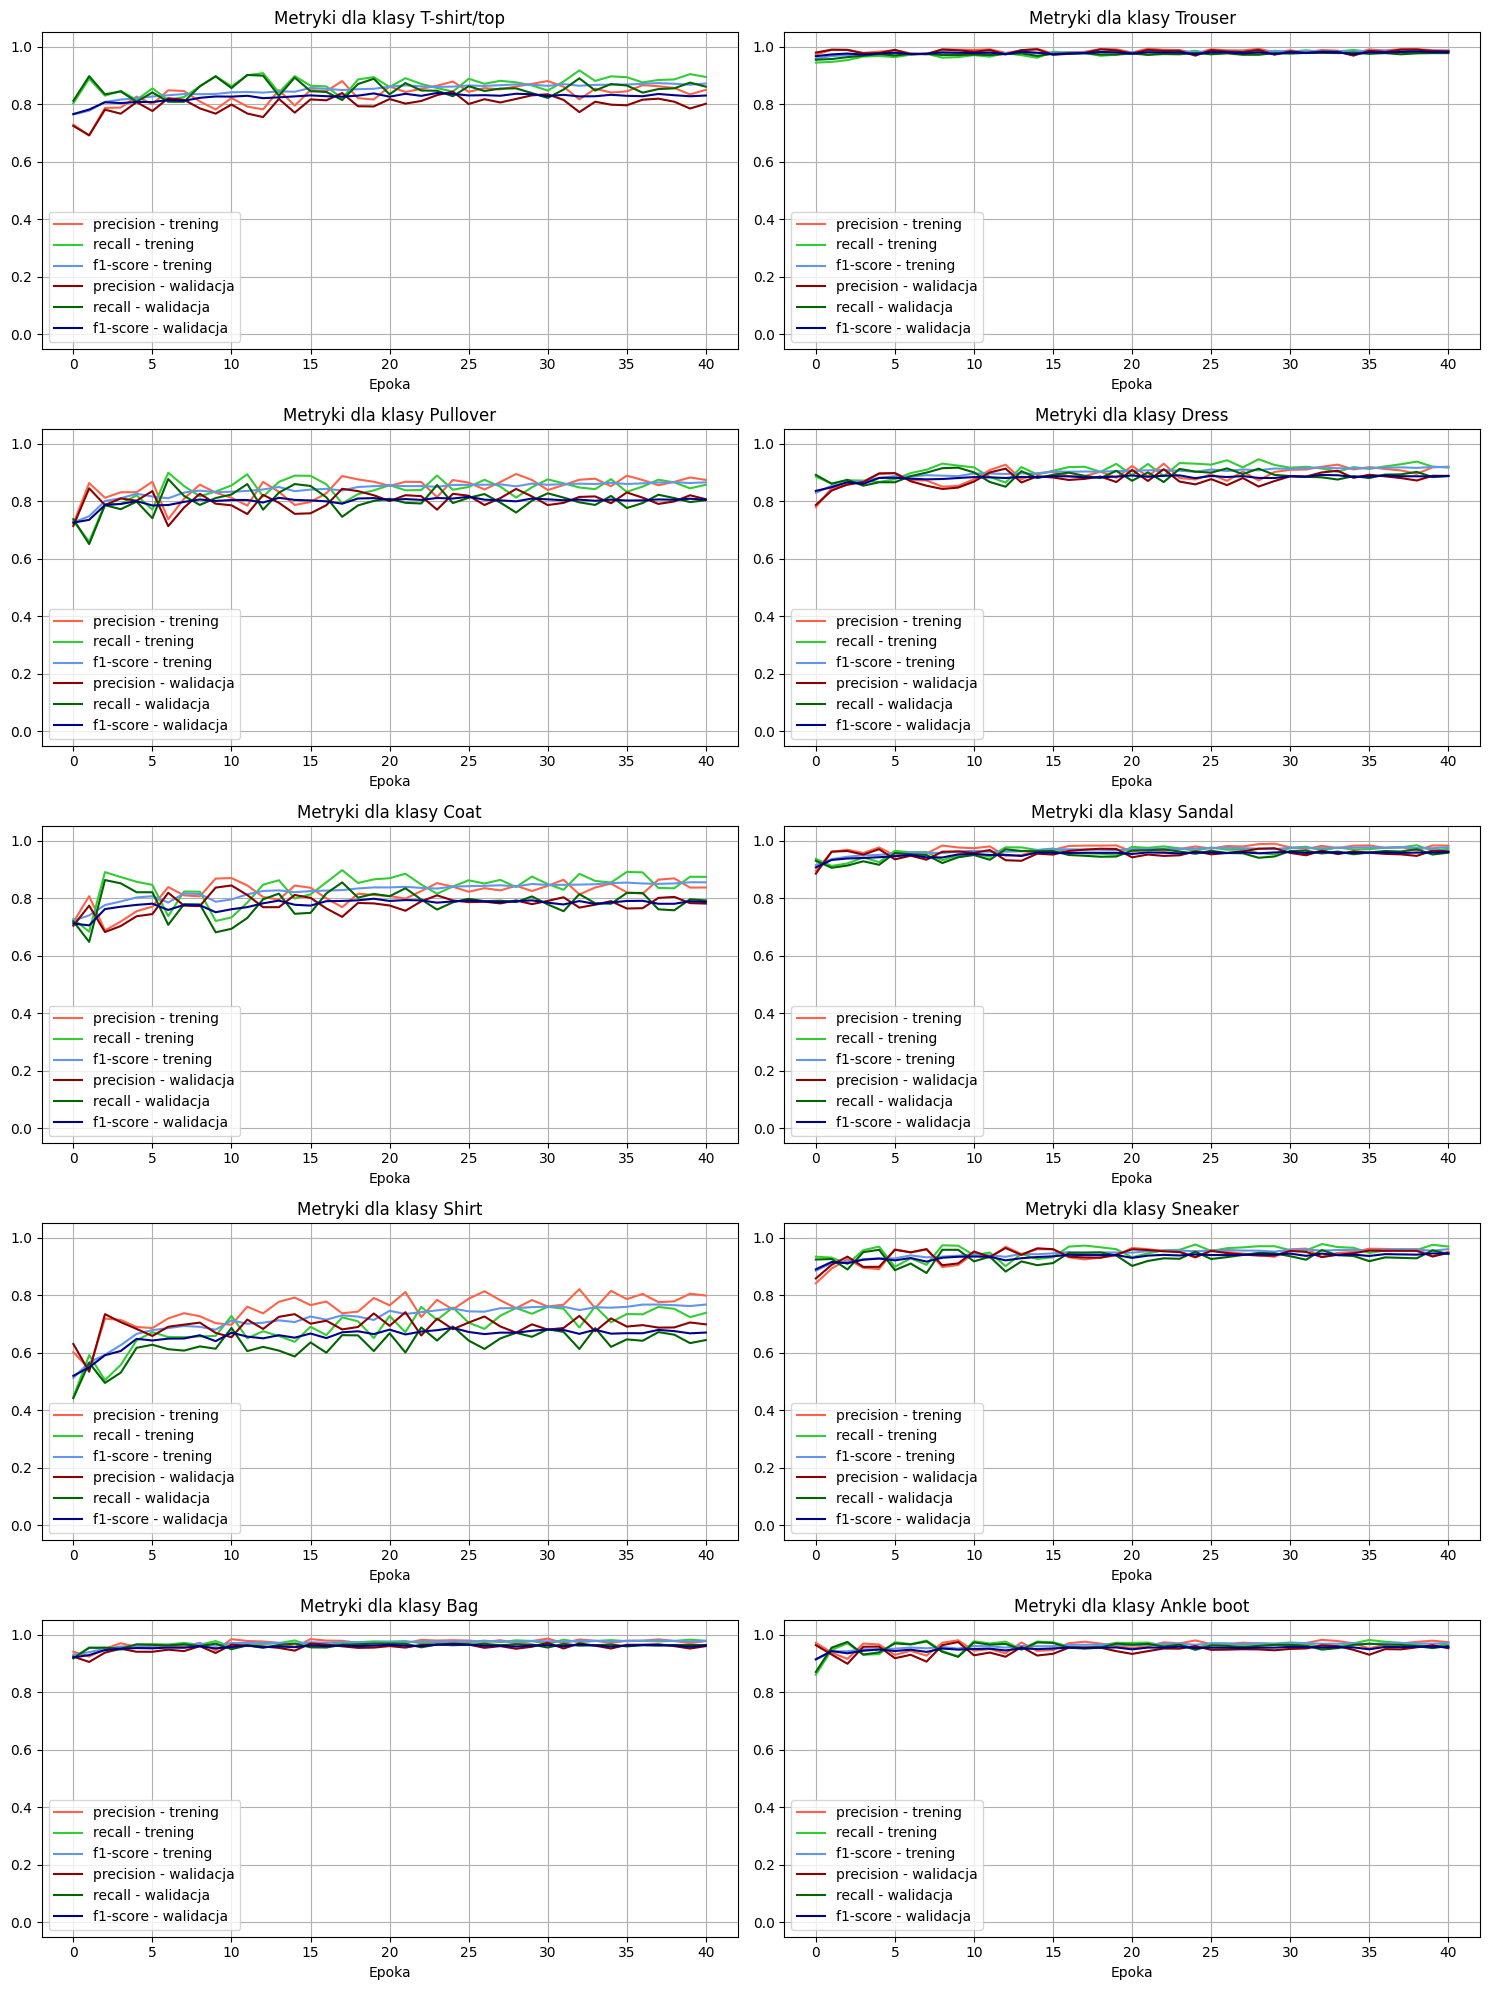

In [ ]:
# parametry warstw
cnn = CNNmodel(pooling='max', global_pooling=True, batch_norm=True, conv_layers_params=[
      (1, 4, 3, 1, 2, 2),
      (4, 8, 3, 1, 2, 2),
      (8, 16, 3, 1, 2, 2),
      (16, 32, 3, 1, 2, 2) # zmiana padding na 2 i dilation na 2
  ])

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num, eta_min=0.0001)

trainer = m.TrainingClass(cnn, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler, patience=15)
tr_losses1, val_losses1, tr_metrics1, val_metrics1, tr_accuracies1, val_accuracies1 = trainer.training_loop(epochs_num, "cnn-modified-conv-layers", trainloader, validationloader, testloader)

m.create_loss_and_accuracy_plot(tr_losses1, val_losses1, tr_accuracies1, val_accuracies1)
m.create_metrics_plot(tr_metrics1, val_metrics1)

In [ ]:
summary(cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNmodel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─BatchNorm2d: 2-2                  [1, 4, 28, 28]            8
│    └─ReLU: 2-3                         [1, 4, 28, 28]            --
│    └─MaxPool2d: 2-4                    [1, 4, 14, 14]            --
│    └─Conv2d: 2-5                       [1, 8, 14, 14]            296
│    └─BatchNorm2d: 2-6                  [1, 8, 14, 14]            16
│    └─ReLU: 2-7                         [1, 8, 14, 14]            --
│    └─MaxPool2d: 2-8                    [1, 8, 7, 7]              --
│    └─Conv2d: 2-9                       [1, 16, 7, 7]             1,168
│    └─BatchNorm2d: 2-10                 [1, 16, 7, 7]             32
│    └─ReLU: 2-11                        [1, 16, 7, 7]             --
│    └─MaxPo

### *Zadanie 5 (dla chętnych)

Wykorzystaj [CAM](https://zilliz.com/learn/class-activation-mapping-CAM) do wizualizacji aktywacji konwolucji dla kilku przykładów ze zbioru testowego. Do tego celu twoja sieć musi koniecznie mieć warstwę Global Avg Pooling, a końcowy moduł FNN być jednowarstwowy.

---
Załadowanie modelu oraz deklaracja odpowiednich funkcji. getActivation() oraz calculate_cam() przekopiowałem ze stronki, natomiast visualize_cam() dostosowałem tak aby przyjmował tensor zamiast obrazu.

In [ ]:
import numpy as np
import cv2
from torchvision import models, transforms
from torch.nn import functional as F

target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
cnn = CNNmodel(pooling='max', global_pooling=True, batch_norm=True, conv_layers_params=[
      (1, 4, 3, 1, 2, 2),
      (4, 8, 3, 1, 2, 2),
      (8, 16, 3, 1, 2, 2),
      (16, 32, 3, 1, 2, 2)
  ])
weights_path = '/content/drive/MyDrive/mlp-models/cnn-modified-conv-layers_weights.pth'
cnn.load_state_dict(torch.load(weights_path, map_location=device))
cnn.eval()

activation = {}
def getActivation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def calculate_cam(feature_conv, weight_fc, class_idx):
    size_upsample = (28, 28)

    bz, nc, h, w = feature_conv.shape

    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)).cpu().numpy())
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    return cam_img

def visualize_cam(class_activation_map, width, height, orig_image_tensor):
    heatmap = cv2.applyColorMap(cv2.resize(class_activation_map,(width, height)), cv2.COLORMAP_JET)
    # przekształcenia tensora
    img = orig_image_tensor.squeeze().cpu().numpy()
    img = (img * 0.5 + 0.5) * 255
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    result = cv2.addWeighted(img, 0.5, heatmap, 0.3, 0) # nałożenie heatmapy na obraz
    img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.imshow(img)

Szkielet całego kodu do wizualizacji predykcji, wykorzystujący powyższe funkcje.

In [ ]:
def visualize_model_outputs(model):
  plt.figure(figsize=(21, 7))
  for x in range(24):
    plt.subplot(3, 8, x+1)
    cnn.layers[12].register_forward_hook(getActivation('final_conv'))

    weight_fc = cnn.layers[-1].weight.detach().cpu().numpy()
    # predykcje
    image_tensor = testset[x][0].unsqueeze(0)
    outputs = cnn(image_tensor)
    class_idx = F.softmax(outputs, dim=1).argmax().item()

    conv_features = activation['final_conv']
    # cam
    class_activation_map = calculate_cam(conv_features, weight_fc, class_idx)
    # wizualizacja
    plt.title(f'Prediction: {target_names[class_idx]}\nreal: {target_names[testset[x][1]]}')
    visualize_cam(class_activation_map, 28, 28, image_tensor.unsqueeze(0))
    plt.tight_layout()

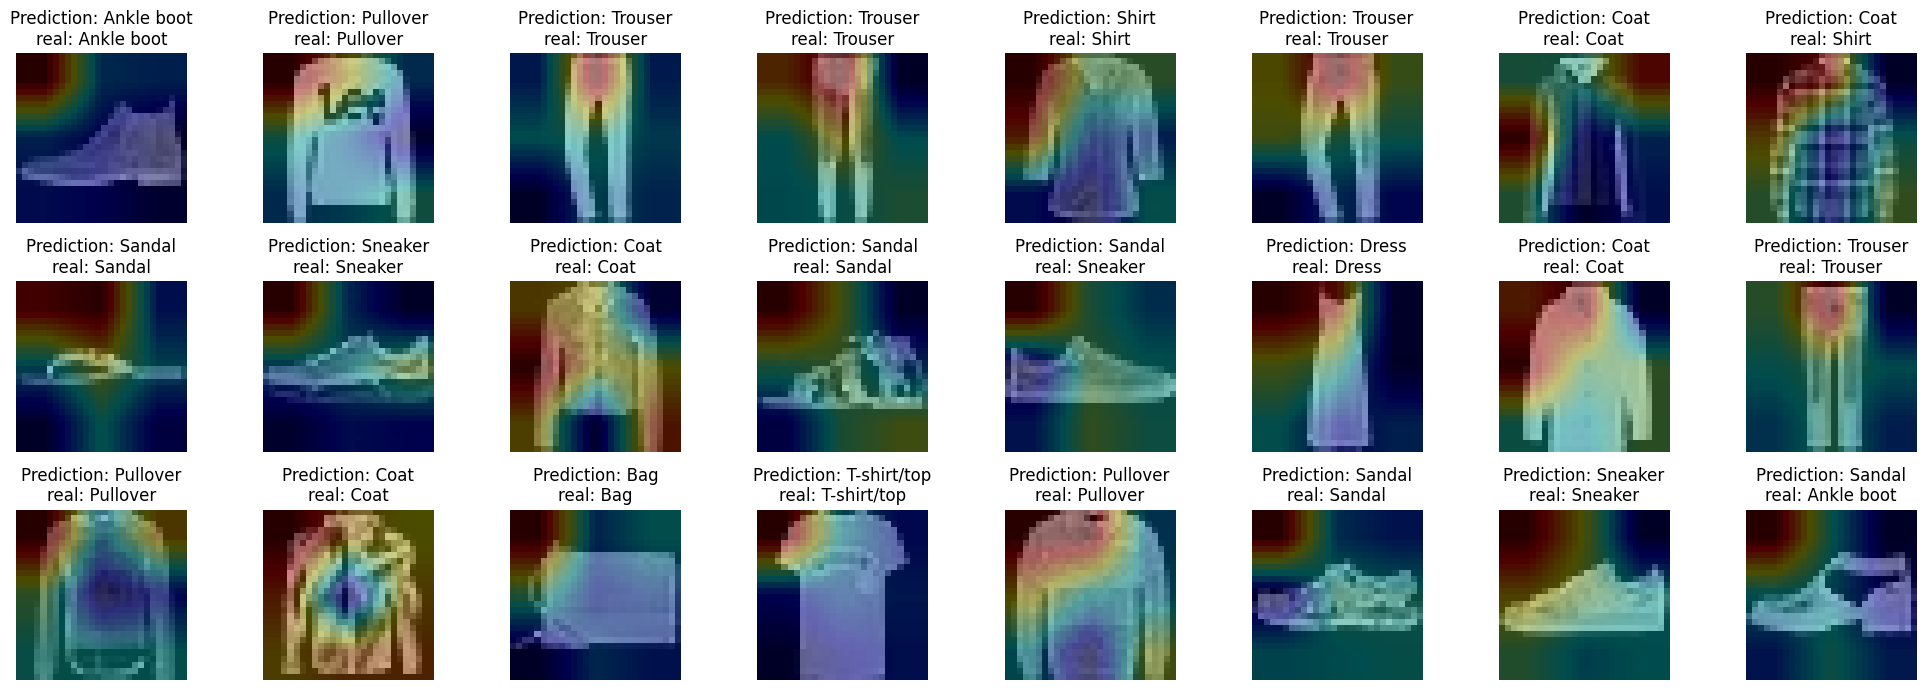

In [ ]:
visualize_model_outputs(cnn)

Powyżej zaprezentowany został przykład predykcji dla ostatniego badanego modelu, gdzie były zmieniane parametry `padding` oraz `dilation`. Choć model dobrze sobie radzi z predykcją klasy o tyle interesujące jest, dlaczego w wielu przypadkach predykcja opiera się na lewym górnym rogu obrazu, co zauważalne jest główne dla butów, sandałów itp.. Z drugiej strony efekt ten jest szczególnie mało zauważalny akurat dla spodni, w których przypadku zwykle decydujący jest środkowy górny obszar.